In [27]:
!pip install -U scikit-image


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import os
import pandas as pd
import pydicom
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import random
import pprint


In [29]:
input_dicom_dir = '../WholePelvis'

In [30]:
series_map = defaultdict(lambda: {'header': None, 'modality': 'Unknown', 'files': []})
file_count = 0
skipped_files = 0

print(f"Scanning directory: {os.path.abspath(input_dicom_dir)}...")

for root, _, files in os.walk(input_dicom_dir):
    for filename in files:
        filepath = os.path.join(root, filename)
        try:
            header = pydicom.dcmread(filepath, stop_before_pixels=True, force=True)
            file_count += 1
            if 'SeriesInstanceUID' not in header or 'Modality' not in header:
                skipped_files += 1
                continue

            series_uid = header.SeriesInstanceUID
            modality = header.Modality.upper()

            if series_map[series_uid]['header'] is None:
                series_map[series_uid]['header'] = header
                series_map[series_uid]['modality'] = modality

            series_map[series_uid]['files'].append(filepath)

        except pydicom.errors.InvalidDicomError:

            skipped_files += 1
            continue
        except Exception as e:
            skipped_files += 1
            continue

print(f"\nScan complete.")
print(f"Processed {file_count} potential DICOM files.")
print(f"Skipped {skipped_files} non-DICOM or problematic files.")
print(f"Found {len(series_map)} unique series.")

Scanning directory: c:\Users\zhaoanr\Desktop\WholePelvis...

Scan complete.
Processed 2992 potential DICOM files.
Skipped 1 non-DICOM or problematic files.
Found 123 unique series.


In [31]:
bins = {
    'PET': {},
    'CT_ORIGINAL': {},      
    'CT_PLANNING_SIM': {}, 
    'CT_OTHER': {},         
    'MRI': {},
    'REG': {},
    'RTSTRUCT': {},
    'RTDOSE': {},
    'RTIMAGE': {},
    'OTHER_MODALITY': {}
}

pet_series_list = [(sid, info) for sid, info in series_map.items() if info['modality'] in ['PT', 'PET']]
original_study_uid = None
original_pet_sid = None

if pet_series_list:
    original_pet_sid, first_pet_info = pet_series_list[0]
    original_study_uid = first_pet_info['header'].StudyInstanceUID
    print(f"Identified original PET/CT Study Instance UID based on PET: ...{str(original_study_uid)[-12:]}")
else:
    print("Warning: No PET series found. Cannot reliably identify original CT vs. Planning CT.")

for series_uid, series_info in series_map.items():
    modality = series_info['modality']
    header = series_info['header']
    study_uid = header.get('StudyInstanceUID', None) 
    series_desc = header.get('SeriesDescription', 'N/A')

    if modality in ['PT', 'PET']:
        bins['PET'][series_uid] = series_info
    elif modality == 'CT':
        if original_study_uid and study_uid == original_study_uid:
            bins['CT_ORIGINAL'][series_uid] = series_info
        elif original_study_uid and study_uid != original_study_uid and \
             any(keyword in series_desc.upper() for keyword in ['SIM', 'PLAN', 'IMAR', 'PELVIS']):
             bins['CT_PLANNING_SIM'][series_uid] = series_info
        elif original_study_uid and study_uid != original_study_uid and len(bins['CT_PLANNING_SIM']) == 0 and \
             len([s for s in series_map.values() if s['modality'] == 'CT' and s['header'].StudyInstanceUID != original_study_uid]) == 1:
             bins['CT_PLANNING_SIM'][series_uid] = series_info
        else:
            bins['CT_OTHER'][series_uid] = series_info 
    elif modality == 'MR' or modality == 'MRI':
         bins['MRI'][series_uid] = series_info
    elif modality == 'REG':
         bins['REG'][series_uid] = series_info
    elif modality == 'RTSTRUCT':
         bins['RTSTRUCT'][series_uid] = series_info
    elif modality == 'RTDOSE':
         bins['RTDOSE'][series_uid] = series_info
    elif modality == 'RTIMAGE':
         bins['RTIMAGE'][series_uid] = series_info
    else:
        bins['OTHER_MODALITY'][series_uid] = series_info

print("\nBinning complete.")

Identified original PET/CT Study Instance UID based on PET: ...452451940488

Binning complete.


In [32]:
print("--- Summary of Found Series ---")
for bin_name, series_dict in bins.items():
    count = len(series_dict)
    print(f"\n{bin_name}: ({count} series)")
    if count > 0:
        for series_uid, series_info in series_dict.items():
            header = series_info['header']
            series_desc = header.get('SeriesDescription', 'N/A')
            num_files = len(series_info['files'])
            study_date = header.get('StudyDate', 'N/A')
            series_date = header.get('SeriesDate', study_date) 

            print(f"  - UID: ...{series_uid[-12:]} | Date: {series_date} | Desc: '{series_desc}' ({num_files} files)")

print("\n--- End of Summary ---\n")

--- Summary of Found Series ---

PET: (1 series)
  - UID: ...438667590801 | Date: 20250425 | Desc: 'PET WB' (366 files)

CT_ORIGINAL: (1 series)
  - UID: ...837981657745 | Date: 20250425 | Desc: 'CT WB  4.0  Br38 iMAR' (366 files)

CT_PLANNING_SIM: (2 series)
  - UID: ...103594119858 | Date: 20250818 | Desc: 'PELVIS  1.5  Bf37  3 iMAR iMAR' (318 files)
  - UID: ...275121431175 | Date: 20250818 | Desc: 'PELVIS  1.5  HD_FoV iMAR iMAR' (318 files)

CT_OTHER: (15 series)
  - UID: ...670102700195 | Date: 20250903 | Desc: 'N/A' (88 files)
  - UID: ...124137560226 | Date: 20250911 | Desc: 'N/A' (88 files)
  - UID: ...949796403605 | Date: 20250922 | Desc: 'N/A' (88 files)
  - UID: ...772118762151 | Date: 20250912 | Desc: 'N/A' (88 files)
  - UID: ...580592650920 | Date: 20250915 | Desc: 'N/A' (88 files)
  - UID: ...502939223462 | Date: 20250902 | Desc: 'N/A' (88 files)
  - UID: ...542978936198 | Date: 20250908 | Desc: 'N/A' (88 files)
  - UID: ...695508680611 | Date: 20250917 | Desc: 'N/A' (88

--- Preparing 3-Row Slice Visualization Grid (Pydicom) ---

Loading and sorting 366 PET files (UID: ...438667590801)...
Loading and sorting 366 CT_ORIGINAL files (UID: ...837981657745)...
Loading and sorting 318 CT_PLANNING_SIM files (UID: ...103594119858)...

Plotting PET (Total Slices: 366). Displaying indices: [163, 173, 183, 193, 203]

Plotting CT_ORIGINAL (Total Slices: 366). Displaying indices: [163, 173, 183, 193, 203]

Plotting CT_PLANNING_SIM (Total Slices: 318). Displaying indices: [163, 173, 183, 193, 203]


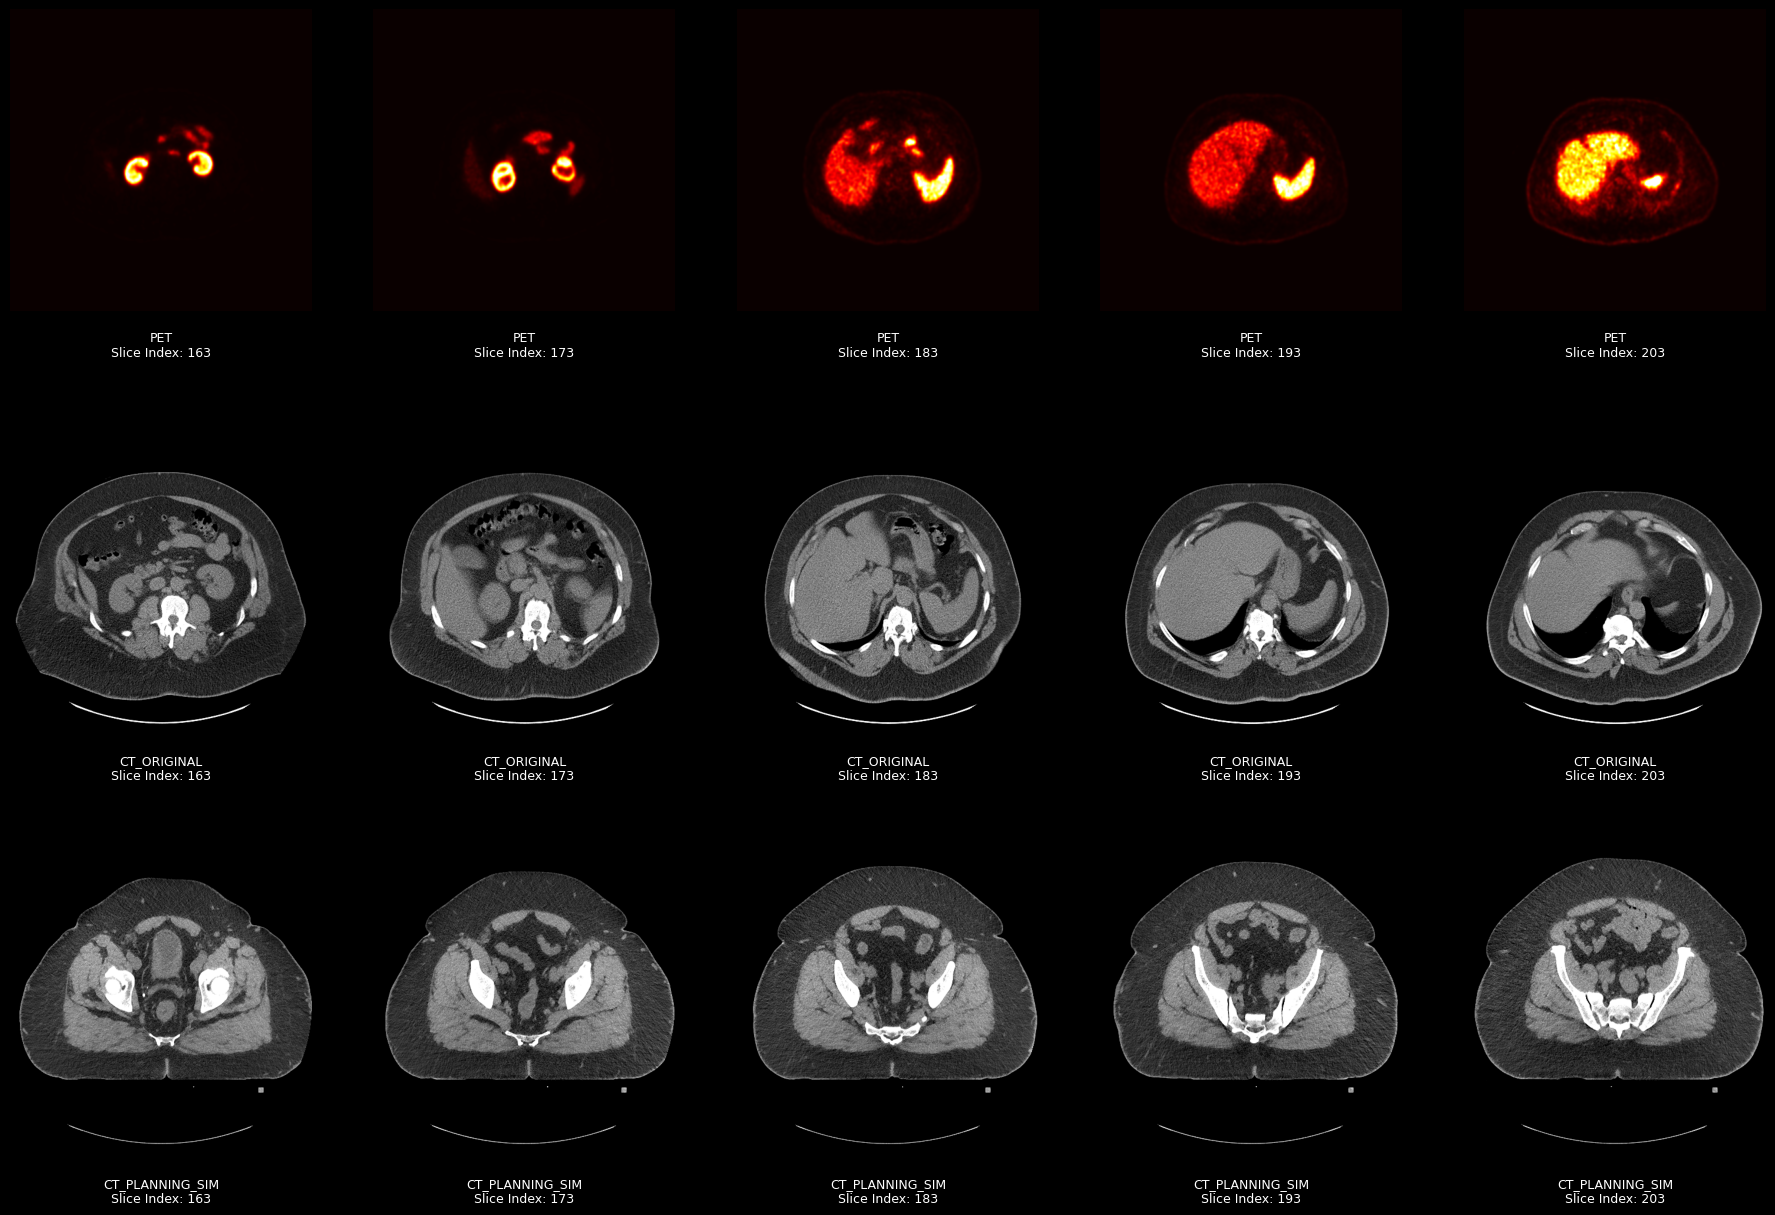

In [33]:
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import os # Import os for basename in error messages

print("--- Preparing 3-Row Slice Visualization Grid (Pydicom) ---")

# --- Helper Function (Assumed to be defined in a previous cell) ---
# def get_sorted_series_data(file_list):
# ... (this function is from your provided code) ...
#
# NOTE: Using a more robust sorter that prefers ImagePositionPatient[2] 
# as 'SliceLocation' can be unreliable.
def get_sorted_series_data_robust(file_list):
    """
    More robustly reads headers and sorts by ImagePositionPatient Z,
    falling back to InstanceNumber if needed.
    Returns a pandas DataFrame.
    """
    slice_data = []
    headers_read = 0
    skipped_count = 0
    if not file_list:
        print("  Error: No files provided to sort.")
        return None
        
    for f in file_list:
        try:
            # Read only necessary tags
            header = pydicom.dcmread(f, stop_before_pixels=True, specific_tags=['ImagePositionPatient', 'InstanceNumber', 'SliceLocation'], force=True)
            headers_read += 1
            sort_key = None
            slice_location_val = None # Keep track for display
            
            # Try to sort by 3D position first (most reliable)
            if 'ImagePositionPatient' in header and len(header.ImagePositionPatient) == 3:
                 try:
                     sort_key = float(header.ImagePositionPatient[2]) # Use Z-coordinate
                     slice_location_val = sort_key # Use Z position as SliceLocation proxy
                 except (TypeError, ValueError):
                      pass # Will try InstanceNumber next

            # Fallback to InstanceNumber if Z position failed
            if sort_key is None and 'InstanceNumber' in header:
                try:
                    sort_key = int(header.InstanceNumber)
                    if 'SliceLocation' in header: slice_location_val = float(header.SliceLocation)
                except (TypeError, ValueError):
                    pass # Skip if InstanceNumber is also invalid

            if sort_key is not None:
                slice_data.append({
                    'filepath': f,
                    'SortKey': sort_key, # Use a generic name for the sorting value
                    'SliceLocationDisplay': slice_location_val
                })
            else:
                 # print(f"  -> Skipping file {os.path.basename(f)}: Missing suitable sort tag.") # Optional debug
                 skipped_count += 1
        except Exception as e:
            # print(f"  -> Skipping file {os.path.basename(f)} during header read: {e}") # Optional debug
            skipped_count += 1

    # print(f"  Attempted to read {headers_read} headers, skipped {skipped_count}.") # Optional Debug
    if not slice_data:
        print("  Error: No sortable slice data found.")
        return None

    df = pd.DataFrame(slice_data)
    df = df.sort_values('SortKey', ascending=True) # Sort numerically
    df = df.reset_index(drop=True)
    return df
# --- End Helper Function ---


# --- Check if necessary bins exist and get UIDs/Files ---
# Assume 'bins' dictionary exists from previous cell
error_flag_viz = False
pet_uid, ct_orig_uid, ct_plan_uid = None, None, None
pet_files, ct_orig_files, ct_plan_files = [], [], []
df_pet, df_ct_orig, df_ct_plan = None, None, None

if 'bins' not in locals():
    print("ERROR: 'bins' dictionary not found. Run binning cells first.")
    error_flag_viz = True
else:
    # Get PET
    if len(bins.get('PET', {})) >= 1:
        pet_uid = list(bins['PET'].keys())[0]
        pet_files = bins['PET'][pet_uid].get('files', [])
        if not pet_files: print("ERROR: PET file list is empty."); error_flag_viz = True
    else: print("ERROR: No PET series found in bins."); error_flag_viz = True

    # Get Original CT
    if len(bins.get('CT_ORIGINAL', {})) >= 1:
        ct_orig_uid = list(bins['CT_ORIGINAL'].keys())[0]
        ct_orig_files = bins['CT_ORIGINAL'][ct_orig_uid].get('files', [])
        if not ct_orig_files: print("ERROR: CT_ORIGINAL file list is empty."); error_flag_viz = True
    else: print("ERROR: No CT_ORIGINAL series found in bins."); error_flag_viz = True

    # Get Planning Sim CT
    if len(bins.get('CT_PLANNING_SIM', {})) >= 1:
        ct_plan_uid = list(bins['CT_PLANNING_SIM'].keys())[0]
        ct_plan_files = bins['CT_PLANNING_SIM'][ct_plan_uid].get('files', [])
        if not ct_plan_files: print("ERROR: CT_PLANNING_SIM file list is empty."); error_flag_viz = True
    else: print("ERROR: No CT_PLANNING_SIM series found in bins."); error_flag_viz = True

# --- Load and Sort Data ---
if not error_flag_viz:
    print(f"\nLoading and sorting {len(pet_files)} PET files (UID: ...{pet_uid[-12:] if pet_uid else 'N/A'})...")
    df_pet = get_sorted_series_data_robust(pet_files)

    print(f"Loading and sorting {len(ct_orig_files)} CT_ORIGINAL files (UID: ...{ct_orig_uid[-12:] if ct_orig_uid else 'N/A'})...")
    df_ct_orig = get_sorted_series_data_robust(ct_orig_files)

    print(f"Loading and sorting {len(ct_plan_files)} CT_PLANNING_SIM files (UID: ...{ct_plan_uid[-12:] if ct_plan_uid else 'N/A'})...")
    df_ct_plan = get_sorted_series_data_robust(ct_plan_files)

# --- Plotting ---
# Check if all DataFrames were created successfully
if df_pet is not None and df_ct_orig is not None and df_ct_plan is not None:
    num_rows = 3 # MODIFIED: Changed to 3 rows
    num_cols = 5
    slice_step = 10
    
    # MODIFIED: Adjusted figsize for 3 rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4.5), facecolor='black')

    # MODIFIED: Added CT_PLANNING_SIM to the plot dictionary
    series_to_plot = {
        'PET': df_pet,
        'CT_ORIGINAL': df_ct_orig,
        'CT_PLANNING_SIM': df_ct_plan
    }
    
    row_index = 0
    for series_name, df_series in series_to_plot.items():
        
        depth = len(df_series)
        
        # --- MODIFIED: Custom slice logic ---
        if series_name == 'CT_PLANNING_SIM':
            # User override: Use specific absolute indices
            slice_indices = [163, 173, 183, 193, 203]
            # Safety check to prevent crashing if indices are out of bounds
            if max(slice_indices) >= depth:
                print(f"ERROR: Requested slice {max(slice_indices)} for {series_name} is out of bounds (max is {depth-1}).")
                # Clamp values to the maximum available slice index
                slice_indices = [min(idx, depth - 1) for idx in slice_indices]
                print(f"  -> Using clamped indices instead: {slice_indices}")
        else:
            # Original proportional logic for PET and CT_ORIGINAL
            # This logic generates: [163, 173, 183, 193, 203] for depth = 366
            start_slice = max(0, depth // 2 - (num_cols // 2 * slice_step))
            slice_indices = [min(start_slice + i * slice_step, depth - 1) for i in range(num_cols)]
        # --- END MODIFICATION ---
            
        print(f"\nPlotting {series_name} (Total Slices: {len(df_series)}). Displaying indices: {slice_indices}")

        for col_index, slice_idx in enumerate(slice_indices):
            ax = axes[row_index, col_index]
            
            try:
                filepath = df_series.iloc[slice_idx]['filepath']
                ds = pydicom.dcmread(filepath)
                
                pixel_array = ds.pixel_array.astype(float)
                
                rescale_intercept = float(ds.get('RescaleIntercept', 0))
                rescale_slope = float(ds.get('RescaleSlope', 1))
                if rescale_slope != 1.0 or rescale_intercept != 0.0:
                    pixel_array = pixel_array * rescale_slope + rescale_intercept
                
                # --- MODIFIED: Apply CT settings to all CTs ---
                if 'CT' in series_name: # Applies to 'CT_ORIGINAL' and 'CT_PLANNING_SIM'
                    window, level = 400, 40 # Standard soft tissue window
                    vmin, vmax = level - window / 2, level + window / 2
                    cmap = 'gray'
                # --- END MODIFICATION ---
                elif series_name == 'PET':
                    # Use percentiles for robust PET display, ignore zeros
                    non_zero_pixels = pixel_array[pixel_array > 1e-6]
                    if non_zero_pixels.size > 0:
                        vmin = np.percentile(non_zero_pixels, 5) # Darken background
                        vmax = np.percentile(non_zero_pixels, 99.8) # Brighten hotspots
                        if vmin >= vmax: vmin = non_zero_pixels.min()
                    else:
                        vmin, vmax = 0, 1 # Fallback
                    cmap = 'hot'
                else: # Fallback for other types
                    vmin, vmax = np.min(pixel_array), np.max(pixel_array)
                    cmap = 'viridis'

                ax.imshow(pixel_array, cmap=cmap, vmin=vmin, vmax=vmax)
                ax.axis('off')
                
                ax.text(0.5, -0.15, f"{series_name}\nSlice Index: {slice_idx}", # Use -0.15 for 3 rows
                        size=9, ha="center", transform=ax.transAxes, color='white')

            except Exception as e_plot:
                 print(f"  -> ERROR plotting slice {slice_idx} for {series_name}: {e_plot}")
                 ax.set_facecolor('red')
                 ax.text(0.5, 0.5, "Error", color='white', ha='center', va='center')
                 ax.axis('off')

        row_index += 1

    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95, hspace=0.4, wspace=0.05) # Adjusted hspace
    fig.suptitle('')
    plt.show()

else:
    # MODIFIED: Updated error message
    print("\nSkipping visualization: could not sort one or more series (PET, CT_ORIGINAL, or CT_PLANNING_SIM).")

# Goals of this project

Contour targets that are PET avid for treatment planning. 

Methods: 
Use Prior radiology PET/CT + treatment planning CT to define translation of PET information to the planning CT for contouring. 

We are going to use 3 image series (PET_1, CT_1 and CT_2)

1) Get all images into 5mm x 5mm x 5mm voxels. The volume for each has to be the same. 128x128x128 or similar. Need to define. Fill edges with zeros as needed. 
2) Use a image registration algorithm to register CT_1 to CT_2




In [34]:
df_pet

,filepath,SortKey,SliceLocationDisplay
0,../WholePelvis\PE.1.2.246.352.221.521376431290...,-1698.5,-1698.5
1,../WholePelvis\PE.1.2.246.352.221.546195834861...,-1695.5,-1695.5
2,../WholePelvis\PE.1.2.246.352.221.484839639473...,-1692.5,-1692.5
3,../WholePelvis\PE.1.2.246.352.221.558231023183...,-1689.5,-1689.5
4,../WholePelvis\PE.1.2.246.352.221.473315500637...,-1686.5,-1686.5
...,...,...,...
361,../WholePelvis\PE.1.2.246.352.221.478407270478...,-615.5,-615.5
362,../WholePelvis\PE.1.2.246.352.221.547228834235...,-612.5,-612.5
363,../WholePelvis\PE.1.2.246.352.221.532908619534...,-609.5,-609.5
364,../WholePelvis\PE.1.2.246.352.221.514411044434...,-606.5,-606.5


In [35]:
# Build CT_1 volume from the sorted CT_ORIGINAL series (df_ct_orig)
# - Reads each slice in order (df_ct_orig is produced by get_sorted_series_data_robust)
# - Applies RescaleSlope/RescaleIntercept when present
# - Handles small shape mismatches by padding/cropping to the first slice shape
import numpy as np
import pydicom
import os

if 'df_ct_orig' not in globals() or df_ct_orig is None:
    print("ERROR: df_ct_orig not found. Run the sorting cells that produce df_ct_orig.")
else:
    depth = len(df_ct_orig)
    if depth == 0:
        print("ERROR: df_ct_orig is empty.")
    else:
        # Read first slice to determine XY shape and dtype
        first_fp = df_ct_orig.iloc[0]['filepath']
        ds0 = pydicom.dcmread(first_fp, force=True)
        arr0 = ds0.pixel_array.astype(float)
        rows, cols = arr0.shape
        # Use float32 to accommodate rescaled CT HUs and avoid overflow
        CT_1 = np.zeros((rows, cols, depth), dtype=np.float32)

        print(f"Building CT_1 volume: target shape (rows,cols,depth) = ({rows},{cols},{depth})")

        for i in range(depth):
            fp = df_ct_orig.iloc[i]['filepath']
            try:
                ds = pydicom.dcmread(fp, force=True)
                im = ds.pixel_array.astype(float)
                slope = float(ds.get('RescaleSlope', 1.0))
                intercept = float(ds.get('RescaleIntercept', 0.0))
                im = im * slope + intercept

                # If shape matches, place directly
                if im.shape == (rows, cols):
                    CT_1[:, :, i] = im
                else:
                    # Handle mismatched slice shapes (pad/crop center-left)
                    r, c = im.shape
                    if r == 0 or c == 0:
                        print(f"  -> slice {i} {os.path.basename(fp)} empty shape {im.shape}, filling with zeros")
                        CT_1[:, :, i] = 0
                    else:
                        # Create temporary padded array then copy overlapping region
                        tmp = np.zeros((rows, cols), dtype=im.dtype)
                        minr = min(r, rows)
                        minc = min(c, cols)
                        tmp[:minr, :minc] = im[:minr, :minc]
                        CT_1[:, :, i] = tmp
                        print(f"  -> warning: slice {i} shape {im.shape} -> padded/cropped to {(rows,cols)}")
            except Exception as e:
                print(f"  -> ERROR reading slice {i} {os.path.basename(fp)}: {e}")
                CT_1[:, :, i] = 0

        # Expose CT_1 in globals for downstream cells
        print(f"CT_1 built: shape={CT_1.shape}, dtype={CT_1.dtype}")


Building CT_1 volume: target shape (rows,cols,depth) = (512,512,366)
CT_1 built: shape=(512, 512, 366), dtype=float32


In [36]:
# Build PET volume from the sorted PET series (df_pet)
# - Applies RescaleSlope/RescaleIntercept when present
# - Pads/crops slices to match the first slice shape
import numpy as np
import pydicom
import os

if 'df_pet' not in globals() or df_pet is None:
    print("ERROR: df_pet not found. Run the sorting cells that produce df_pet.")
else:
    depth = len(df_pet)
    if depth == 0:
        print("ERROR: df_pet is empty.")
    else:
        first_fp = df_pet.iloc[0]['filepath']
        ds0 = pydicom.dcmread(first_fp, force=True)
        arr0 = ds0.pixel_array.astype(float)
        rows, cols = arr0.shape
        PET = np.zeros((rows, cols, depth), dtype=np.float32)

        print(f"Building PET volume: target shape (rows,cols,depth) = ({rows},{cols},{depth})")

        for i in range(depth):
            fp = df_pet.iloc[i]['filepath']
            try:
                ds = pydicom.dcmread(fp, force=True)
                im = ds.pixel_array.astype(float)
                slope = float(ds.get('RescaleSlope', 1.0))
                intercept = float(ds.get('RescaleIntercept', 0.0))
                im = im * slope + intercept

                if im.shape == (rows, cols):
                    PET[:, :, i] = im
                else:
                    r, c = im.shape
                    if r == 0 or c == 0:
                        print(f"  -> PET slice {i} {os.path.basename(fp)} empty shape {im.shape}, filling with zeros")
                        PET[:, :, i] = 0
                    else:
                        tmp = np.zeros((rows, cols), dtype=im.dtype)
                        minr = min(r, rows)
                        minc = min(c, cols)
                        tmp[:minr, :minc] = im[:minr, :minc]
                        PET[:, :, i] = tmp
                        print(f"  -> warning: PET slice {i} shape {im.shape} -> padded/cropped to {(rows,cols)}")
            except Exception as e:
                print(f"  -> ERROR reading PET slice {i} {os.path.basename(fp)}: {e}")
                PET[:, :, i] = 0

        print(f"PET built: shape={PET.shape}, dtype={PET.dtype}")

# Expose PET volume variable for downstream processing

Building PET volume: target shape (rows,cols,depth) = (440,440,366)
PET built: shape=(440, 440, 366), dtype=float32


In [37]:
# Build CT_2 (planning CT) volume from the sorted CT_PLANNING_SIM series (df_ct_plan)
# - Similar behavior to CT_1 assembly; result stored in CT_2
import numpy as np
import pydicom
import os

if 'df_ct_plan' not in globals() or df_ct_plan is None:
    print("ERROR: df_ct_plan not found. Run the sorting cells that produce df_ct_plan.")
else:
    depth = len(df_ct_plan)
    if depth == 0:
        print("ERROR: df_ct_plan is empty.")
    else:
        first_fp = df_ct_plan.iloc[0]['filepath']
        ds0 = pydicom.dcmread(first_fp, force=True)
        arr0 = ds0.pixel_array.astype(float)
        rows, cols = arr0.shape
        CT_2 = np.zeros((rows, cols, depth), dtype=np.float32)

        print(f"Building CT_2 volume: target shape (rows,cols,depth) = ({rows},{cols},{depth})")

        for i in range(depth):
            fp = df_ct_plan.iloc[i]['filepath']
            try:
                ds = pydicom.dcmread(fp, force=True)
                im = ds.pixel_array.astype(float)
                slope = float(ds.get('RescaleSlope', 1.0))
                intercept = float(ds.get('RescaleIntercept', 0.0))
                im = im * slope + intercept

                if im.shape == (rows, cols):
                    CT_2[:, :, i] = im
                else:
                    r, c = im.shape
                    if r == 0 or c == 0:
                        print(f"  -> CT_2 slice {i} {os.path.basename(fp)} empty shape {im.shape}, filling with zeros")
                        CT_2[:, :, i] = 0
                    else:
                        tmp = np.zeros((rows, cols), dtype=im.dtype)
                        minr = min(r, rows)
                        minc = min(c, cols)
                        tmp[:minr, :minc] = im[:minr, :minc]
                        CT_2[:, :, i] = tmp
                        print(f"  -> warning: CT_2 slice {i} shape {im.shape} -> padded/cropped to {(rows,cols)}")
            except Exception as e:
                print(f"  -> ERROR reading CT_2 slice {i} {os.path.basename(fp)}: {e}")
                CT_2[:, :, i] = 0

        print(f"CT_2 built: shape={CT_2.shape}, dtype={CT_2.dtype}")

Building CT_2 volume: target shape (rows,cols,depth) = (512,512,318)
CT_2 built: shape=(512, 512, 318), dtype=float32


In [38]:
CT_1.shape

(512, 512, 366)

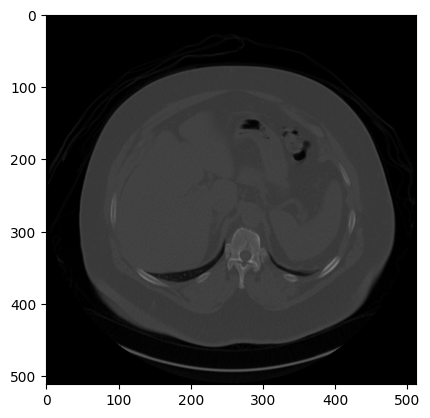

In [39]:
plt.imshow(CT_1[:, :, CT_1.shape[2] // 2], cmap='gray', vmin=-1000, vmax=3000)

CT_1 (512, 512, 366) float32
PET (440, 440, 366) float32
CT_2 (512, 512, 318) float32


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

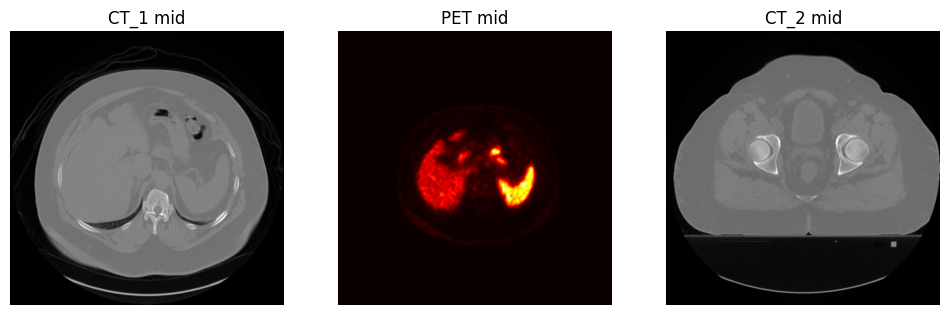

In [40]:
print('CT_1', CT_1.shape, CT_1.dtype)
print('PET', PET.shape, PET.dtype)
print('CT_2', CT_2.shape, CT_2.dtype)

# Visual quick check (middle slice)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(CT_1[:,:,CT_1.shape[2]//2], cmap='gray'); plt.title('CT_1 mid'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(PET[:,:,PET.shape[2]//2], cmap='hot'); plt.title('PET mid'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(CT_2[:,:,CT_2.shape[2]//2], cmap='gray'); plt.title('CT_2 mid'); plt.axis('off')

Note: cropping to common shape (440,440) from CT (512,512) and PET (440,440)


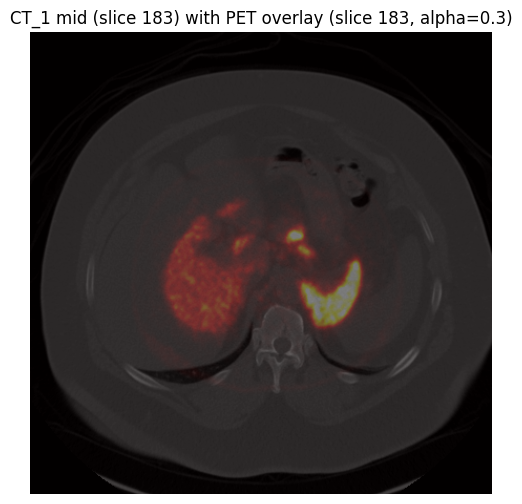

In [41]:
# Overlay PET mid-slice on CT_1 mid-slice (alpha=0.3) for registration QC
import matplotlib.pyplot as plt
import numpy as np

if 'CT_1' not in globals() or 'PET' not in globals():
    print("ERROR: CT_1 and PET must be built first. Run assembly cells.")
else:
    mid_ct = CT_1.shape[2] // 2
    mid_pet = PET.shape[2] // 2
    ct_slice = CT_1[:, :, mid_ct]
    pet_slice = PET[:, :, mid_pet]

    # Center-crop to smallest common shape if needed
    r_ct, c_ct = ct_slice.shape
    r_pet, c_pet = pet_slice.shape
    r = min(r_ct, r_pet)
    c = min(c_ct, c_pet)

    def center_crop(arr, target_r, target_c):
        rr, cc = arr.shape
        start_r = max(0, (rr - target_r)//2)
        start_c = max(0, (cc - target_c)//2)
        return arr[start_r:start_r+target_r, start_c:start_c+target_c]

    if (r, c) != (r_ct, c_ct) or (r, c) != (r_pet, c_pet):
        print(f"Note: cropping to common shape ({r},{c}) from CT ({r_ct},{c_ct}) and PET ({r_pet},{c_pet})")

    ct_crop = center_crop(ct_slice, r, c)
    pet_crop = center_crop(pet_slice, r, c)

    # Normalize PET for display (robust percentiles)
    nonzero = pet_crop[pet_crop > 1e-6]
    if nonzero.size > 0:
        pmin = np.percentile(nonzero, 5)
        pmax = np.percentile(nonzero, 99.8)
        if pmax <= pmin:
            pmin = nonzero.min()
            pmax = nonzero.max() if nonzero.max() > pmin else pmin + 1.0
        pet_display = np.clip((pet_crop - pmin) / (pmax - pmin), 0, 1)
    else:
        # fallback linear normalization
        mn = pet_crop.min()
        mx = pet_crop.max()
        pet_display = (pet_crop - mn) / (mx - mn) if mx != mn else np.zeros_like(pet_crop)

    plt.figure(figsize=(6,6))
    plt.imshow(ct_crop, cmap='gray', vmin=-1000, vmax=3000)
    plt.imshow(pet_display, cmap='hot', alpha=0.3, vmin=0, vmax=1)
    plt.title(f'CT_1 mid (slice {mid_ct}) with PET overlay (slice {mid_pet}, alpha=0.3)')
    plt.axis('off')
    plt.show()

Resampling CT_1 from (512, 512) and PET from (440, 440) to (256,256)
Using scipy.ndimage.zoom for resampling
CT_1_res shape: (256, 256, 366), PET_res shape: (256, 256, 366)


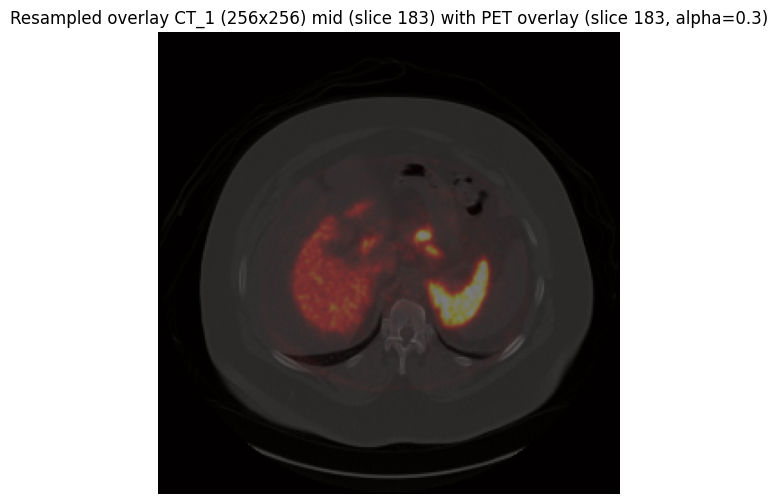

In [42]:
# Resample CT_1 and PET to target XY resolution (256x256) then re-overlay mid slices
# Tries scipy.ndimage.zoom, falls back to skimage.transform.resize or PIL if needed
import numpy as np
import matplotlib.pyplot as plt
import warnings

TARGET_ROWS, TARGET_COLS = 256, 256

if 'CT_1' not in globals() or 'PET' not in globals():
    print('ERROR: CT_1 and PET must be built first. Run assembly cells.')
else:
    print(f'Resampling CT_1 from {CT_1.shape[:2]} and PET from {PET.shape[:2]} to ({TARGET_ROWS},{TARGET_COLS})')

    # Choose resampling function with fallbacks
    resample_fn = None
    try:
        from scipy.ndimage import zoom
        def _resample_slice(arr, out_shape):
            ry = out_shape[0] / arr.shape[0]
            rx = out_shape[1] / arr.shape[1]
            return zoom(arr, (ry, rx), order=1)  # linear interpolation
        resample_fn = _resample_slice
        print('Using scipy.ndimage.zoom for resampling')
    except Exception as e1:
        try:
            from skimage.transform import resize
            def _resample_slice(arr, out_shape):
                return resize(arr, out_shape, order=1, preserve_range=True, anti_aliasing=True)
            resample_fn = _resample_slice
            print('Using skimage.transform.resize for resampling')
        except Exception as e2:
            try:
                from PIL import Image
                def _resample_slice(arr, out_shape):
                    # PIL expects uint8/uint16; scale to float and back safely
                    arr_min, arr_max = arr.min(), arr.max()
                    if arr_max == arr_min:
                        return np.zeros(out_shape, dtype=arr.dtype)
                    norm = (arr - arr_min) / (arr_max - arr_min)
                    im = Image.fromarray((norm * 65535).astype('uint16'))
                    im2 = im.resize((out_shape[1], out_shape[0]), resample=Image.BILINEAR)
                    arr2 = np.array(im2).astype(float) / 65535.0
                    return arr2 * (arr_max - arr_min) + arr_min
                resample_fn = _resample_slice
                print('Using PIL.Image.resize for resampling (fallback)')
            except Exception as e3:
                warnings.warn('No resampling backend (scipy/skimage/PIL) available. Install scipy or scikit-image for resampling.')

    if resample_fn is None:
        raise RuntimeError('No resampling function available. Please pip install scipy or scikit-image or pillow')

    # Resample each slice for CT_1 and PET independently (preserve depth)
    def resample_volume(vol, out_rows, out_cols):
        rows, cols, depth = vol.shape
        out_vol = np.zeros((out_rows, out_cols, depth), dtype=np.float32)
        for z in range(depth):
            try:
                out_vol[:, :, z] = resample_fn(vol[:, :, z], (out_rows, out_cols))
            except Exception as e:
                print(f'  -> Error resampling slice {z}: {e}')
                out_vol[:, :, z] = 0
        return out_vol

    CT_1_res = resample_volume(CT_1, TARGET_ROWS, TARGET_COLS)
    PET_res = resample_volume(PET, TARGET_ROWS, TARGET_COLS)

    print(f'CT_1_res shape: {CT_1_res.shape}, PET_res shape: {PET_res.shape}')

    # Overlay resampled mid slices
    mid_ct = CT_1_res.shape[2] // 2
    mid_pet = PET_res.shape[2] // 2
    ct_slice = CT_1_res[:, :, mid_ct]
    pet_slice = PET_res[:, :, mid_pet]

    # Normalize PET for display (robust percentiles)
    nonzero = pet_slice[pet_slice > 1e-6]
    if nonzero.size > 0:
        pmin = np.percentile(nonzero, 5)
        pmax = np.percentile(nonzero, 99.8)
        if pmax <= pmin:
            pmin = nonzero.min(); pmax = nonzero.max() if nonzero.max() > pmin else pmin + 1.0
        pet_display = np.clip((pet_slice - pmin) / (pmax - pmin), 0, 1)
    else:
        mn = pet_slice.min(); mx = pet_slice.max()
        pet_display = (pet_slice - mn) / (mx - mn) if mx != mn else np.zeros_like(pet_slice)

    plt.figure(figsize=(6,6))
    plt.imshow(ct_slice, cmap='gray', vmin=-1000, vmax=3000)
    plt.imshow(pet_display, cmap='hot', alpha=0.3, vmin=0, vmax=1)
    plt.title(f'Resampled overlay CT_1 ({TARGET_ROWS}x{TARGET_COLS}) mid (slice {mid_ct}) with PET overlay (slice {mid_pet}, alpha=0.3)')
    plt.axis('off')
    plt.show()

Using scipy.ndimage.zoom to resample PET to CT native size


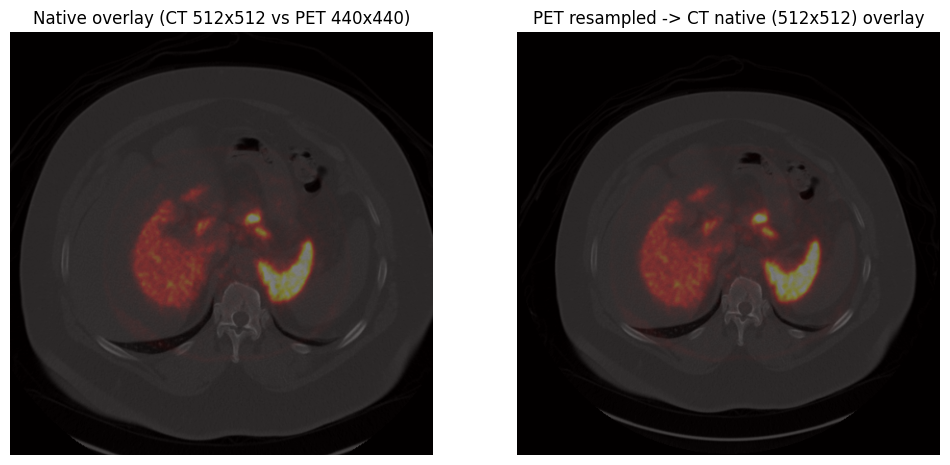

In [43]:
# Compare native-resolution overlay vs PET resampled to CT native size
import numpy as np
import matplotlib.pyplot as plt
import warnings

if 'CT_1' not in globals() or 'PET' not in globals():
    print('ERROR: CT_1 and PET must be built first. Run assembly cells.')
else:
    # Native slices (no resampling) - center-crop to common shape for visualization
    mid_ct = CT_1.shape[2] // 2
    mid_pet = PET.shape[2] // 2
    ct_native = CT_1[:, :, mid_ct]
    pet_native = PET[:, :, mid_pet]
    r_ct, c_ct = ct_native.shape
    r_pet, c_pet = pet_native.shape
    r_common = min(r_ct, r_pet)
    c_common = min(c_ct, c_pet)

    def center_crop(arr, tr, tc):
        rr, cc = arr.shape
        sr = max(0, (rr - tr)//2)
        sc = max(0, (cc - tc)//2)
        return arr[sr:sr+tr, sc:sc+tc]

    ct_crop = center_crop(ct_native, r_common, c_common)
    pet_crop = center_crop(pet_native, r_common, c_common)

    # Normalize PET for display
    def pet_norm_for_display(pet_arr):
        nonzero = pet_arr[pet_arr > 1e-6]
        if nonzero.size > 0:
            pmin = np.percentile(nonzero, 5)
            pmax = np.percentile(nonzero, 99.8)
            if pmax <= pmin:
                pmin = nonzero.min(); pmax = nonzero.max() if nonzero.max() > pmin else pmin + 1.0
            return np.clip((pet_arr - pmin) / (pmax - pmin), 0, 1)
        else:
            mn = pet_arr.min(); mx = pet_arr.max()
            return (pet_arr - mn) / (mx - mn) if mx != mn else np.zeros_like(pet_arr)

    pet_crop_display = pet_norm_for_display(pet_crop)

    # Now resample PET native slice to CT native XY shape (no depth change)
    rows_target, cols_target = r_ct, c_ct

    resample_fn = None
    try:
        from scipy.ndimage import zoom
        def _resample(arr, out_shape):
            ry = out_shape[0] / arr.shape[0]
            rx = out_shape[1] / arr.shape[1]
            return zoom(arr, (ry, rx), order=1)
        resample_fn = _resample
        print('Using scipy.ndimage.zoom to resample PET to CT native size')
    except Exception:
        try:
            from skimage.transform import resize
            def _resample(arr, out_shape):
                return resize(arr, out_shape, order=1, preserve_range=True, anti_aliasing=True)
            resample_fn = _resample
            print('Using skimage.transform.resize to resample PET to CT native size')
        except Exception:
            try:
                from PIL import Image
                def _resample(arr, out_shape):
                    arr_min, arr_max = arr.min(), arr.max()
                    if arr_max == arr_min:
                        return np.zeros(out_shape, dtype=arr.dtype)
                    norm = (arr - arr_min) / (arr_max - arr_min)
                    im = Image.fromarray((norm * 65535).astype('uint16'))
                    im2 = im.resize((out_shape[1], out_shape[0]), resample=Image.BILINEAR)
                    arr2 = np.array(im2).astype(float) / 65535.0
                    return arr2 * (arr_max - arr_min) + arr_min
                resample_fn = _resample
                print('Using PIL.Image.resize to resample PET to CT native size')
            except Exception:
                warnings.warn('No resampling backend available (scipy/skimage/PIL). Install one and retry.')

    if resample_fn is None:
        raise RuntimeError('No resampling backend available; please pip install scipy or scikit-image or pillow')

    pet_resampled_to_ct = resample_fn(pet_native, (rows_target, cols_target))
    pet_resampled_display = pet_norm_for_display(pet_resampled_to_ct)

    # Prepare figure: left = native overlay (center-crop), right = PET resampled to CT native size overlay
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.imshow(ct_crop, cmap='gray', vmin=-1000, vmax=3000)
    plt.imshow(pet_crop_display, cmap='hot', alpha=0.3)
    plt.title(f'Native overlay (CT {r_ct}x{c_ct} vs PET {r_pet}x{c_pet})')
    plt.axis('off')

    plt.subplot(1,2,2)
    # Crop CT native to match target (should be same already)
    ct_for_right = ct_native if ct_native.shape == (rows_target, cols_target) else center_crop(ct_native, rows_target, cols_target)
    plt.imshow(ct_for_right, cmap='gray', vmin=-1000, vmax=3000)
    plt.imshow(pet_resampled_display, cmap='hot', alpha=0.3)
    plt.title(f'PET resampled -> CT native ({rows_target}x{cols_target}) overlay')
    plt.axis('off')

    plt.show()

In [44]:
import pydicom
print("CT_1 shape:", CT_1.shape)
print("PET shape:", PET.shape)

# show PixelSpacing / ImagePositionPatient for first file used
def print_tags(df, name):
    fp = df.iloc[0]['filepath']
    ds = pydicom.dcmread(fp, stop_before_pixels=True, force=True)
    print(f"{name}: PixelSpacing={ds.get('PixelSpacing', 'N/A')}, ImagePositionPatient={ds.get('ImagePositionPatient','N/A')}, Rows/Cols={ds.Rows}/{ds.Columns}")

print_tags(df_ct_orig, "CT (first slice)")
print_tags(df_pet, "PET (first slice)")

CT_1 shape: (512, 512, 366)
PET shape: (440, 440, 366)
CT (first slice): PixelSpacing=[0.9765625, 0.9765625], ImagePositionPatient=[-249.51171875, -473.01171875, -1698.5], Rows/Cols=512/512
PET (first slice): PixelSpacing=[1.65, 1.65], ImagePositionPatient=[-363.438, -586.794, -1698.5], Rows/Cols=440/440


Meta: {'ct_pixelspacing': [0.9765625, 0.9765625], 'pet_pixelspacing': [1.65, 1.65], 'ct_ipp': [-249.51171875, -473.01171875, -1149.5], 'pet_ipp': [-363.438, -586.794, -1149.5]}


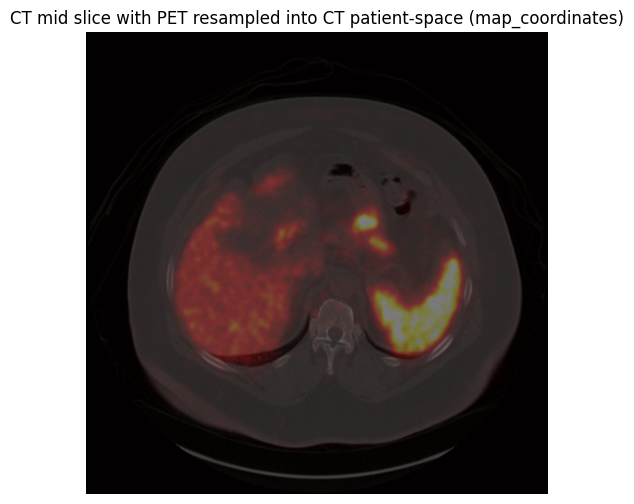

In [45]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

# Coordinate-based resampling: sample PET into CT patient space (single-slice example)
def resample_pet_to_ct_slice(df_ct, df_pet, slice_idx_ct=None, slice_idx_pet=None, order=1):
    """Resample a PET slice into the CT image grid using DICOM spatial metadata.
    Returns: resampled_pet (2D array), ct_slice (2D array)"""
    # choose mid slices if not provided
    if slice_idx_ct is None:
        slice_idx_ct = len(df_ct) // 2
    if slice_idx_pet is None:
        slice_idx_pet = len(df_pet) // 2

    # Read headers (no pixels needed for spacing/origin/orientation)
    ds_ct = pydicom.dcmread(df_ct.iloc[slice_idx_ct]['filepath'], stop_before_pixels=True, force=True)
    ds_pet = pydicom.dcmread(df_pet.iloc[slice_idx_pet]['filepath'], stop_before_pixels=True, force=True)

    # Pixel spacing (row, col) and origins
    ps_ct = [float(x) for x in ds_ct.get('PixelSpacing', [1.0, 1.0])]
    ps_pet = [float(x) for x in ds_pet.get('PixelSpacing', [1.0, 1.0])]
    ipp_ct = np.array([float(x) for x in ds_ct.get('ImagePositionPatient', [0.0,0.0,0.0])], dtype=float)
    ipp_pet = np.array([float(x) for x in ds_pet.get('ImagePositionPatient', [0.0,0.0,0.0])], dtype=float)

    # Orientation (direction cosines). DICOM gives [row_x,row_y,row_z, col_x,col_y,col_z]
    iop_ct = [float(x) for x in ds_ct.get('ImageOrientationPatient', [1,0,0,0,1,0])]
    iop_pet = [float(x) for x in ds_pet.get('ImageOrientationPatient', [1,0,0,0,1,0])]
    row_cos_ct = np.array(iop_ct[0:3], dtype=float)
    col_cos_ct = np.array(iop_ct[3:6], dtype=float)
    row_cos_pet = np.array(iop_pet[0:3], dtype=float)
    col_cos_pet = np.array(iop_pet[3:6], dtype=float)

    # Read pixel data for the slices we will use
    ds_ct_pix = pydicom.dcmread(df_ct.iloc[slice_idx_ct]['filepath'], force=True)
    ds_pet_pix = pydicom.dcmread(df_pet.iloc[slice_idx_pet]['filepath'], force=True)
    ct_slice = ds_ct_pix.pixel_array.astype(float)
    pet_slice = ds_pet_pix.pixel_array.astype(float)
    # apply rescale if present
    ct_slice = ct_slice * float(ds_ct_pix.get('RescaleSlope', 1.0)) + float(ds_ct_pix.get('RescaleIntercept', 0.0))
    pet_slice = pet_slice * float(ds_pet_pix.get('RescaleSlope', 1.0)) + float(ds_pet_pix.get('RescaleIntercept', 0.0))

    rows_ct, cols_ct = ct_slice.shape
    rows_pet, cols_pet = pet_slice.shape

    # Build CT grid of (row, col) indices
    rr = np.arange(rows_ct)
    cc = np.arange(cols_ct)
    grid_r, grid_c = np.meshgrid(rr, cc, indexing='ij')  # shape (rows, cols)

    # Compute patient coordinates of each CT pixel center: P = ipp_ct + c*row_cos_ct*col_spacing + r*col_cos_ct*row_spacing
    pts = (ipp_ct.reshape(1,1,3) +
           grid_c[:,:,None] * row_cos_ct.reshape(1,1,3) * ps_ct[1] +
           grid_r[:,:,None] * col_cos_ct.reshape(1,1,3) * ps_ct[0])
    # pts shape (rows_ct, cols_ct, 3)

    # Vector from PET origin to each CT pixel
    diff = pts - ipp_pet.reshape(1,1,3)

    # Project onto PET row/col cosines to get fractional column/row indices in PET image space
    # col_pet = dot(diff, row_cos_pet) / pet_col_spacing ; row_pet = dot(diff, col_cos_pet) / pet_row_spacing
    pet_col_spacing = ps_pet[1]
    pet_row_spacing = ps_pet[0]
    col_pet = np.tensordot(diff, row_cos_pet, axes=([2],[0])) / pet_col_spacing
    row_pet = np.tensordot(diff, col_cos_pet, axes=([2],[0])) / pet_row_spacing

    # Prepare coordinates for map_coordinates: coords = [row_coords_flat, col_coords_flat]
    coords = np.vstack([row_pet.ravel(), col_pet.ravel()])

    # Sample PET at those continuous coordinates (order=1 linear). Out-of-bounds are set to 0.
    pet_resampled_flat = map_coordinates(pet_slice, coords, order=order, mode='constant', cval=0.0)
    pet_resampled = pet_resampled_flat.reshape(rows_ct, cols_ct)

    return ct_slice, pet_resampled, {
        'ct_pixelspacing': ps_ct, 'pet_pixelspacing': ps_pet,
        'ct_ipp': ipp_ct.tolist(), 'pet_ipp': ipp_pet.tolist()
    }

# Run the resampling for mid slices and display overlay
ct_slice, pet_resampled, meta = resample_pet_to_ct_slice(df_ct_orig, df_pet)
print('Meta:', meta)

# Normalize PET for display
def norm_for_display(arr):
    nonzero = arr[arr > 1e-6]
    if nonzero.size > 0:
        pmin = np.percentile(nonzero, 5)
        pmax = np.percentile(nonzero, 99.8)
        if pmax <= pmin: pmin, pmax = nonzero.min(), nonzero.max() if nonzero.max()>nonzero.min() else (nonzero.min(), nonzero.min()+1.0)
        return np.clip((arr - pmin) / (pmax - pmin), 0, 1)
    else:
        mn, mx = arr.min(), arr.max()
        return (arr - mn) / (mx - mn) if mx != mn else np.zeros_like(arr)

pet_disp = norm_for_display(pet_resampled)

plt.figure(figsize=(6,6))
plt.imshow(ct_slice, cmap='gray', vmin=-1000, vmax=3000)
plt.imshow(pet_disp, cmap='hot', alpha=0.3)
plt.title('CT mid slice with PET resampled into CT patient-space (map_coordinates)')
plt.axis('off')
plt.show()

CT slice idx (by index): 183 CT Z: -1149.5
Matched PET slice idx: 183 PET Z: -1149.5

CT PixelSpacing, RowsxCols: [0.9765625, 0.9765625] 512 x 512
PET PixelSpacing, RowsxCols: [1.65, 1.65] 440 x 440

CT FOV (mm) x,y: (500.0, 500.0)
PET FOV (mm) x,y: (726.0, 726.0)

CT image center (patient coords): [    0.   -223.5 -1149.5]
PET image center (patient coords): [   -1.263  -224.619 -1149.5  ]

Center offset (PET_center - CT_center) [mm]: [-1.263 -1.119  0.   ]


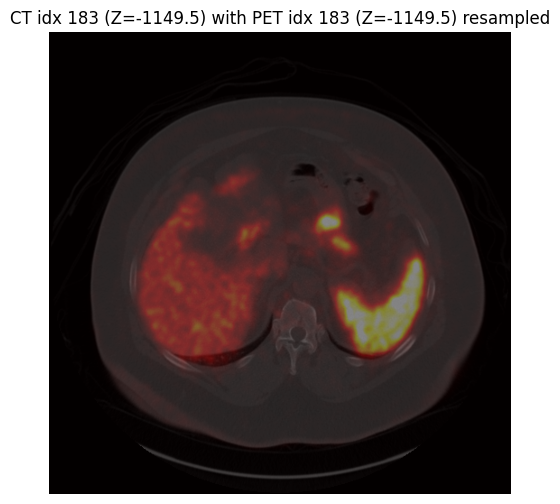

In [46]:
# ...existing code...
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

def slice_ipp_and_spacing(df, idx):
    ds = pydicom.dcmread(df.iloc[idx]['filepath'], stop_before_pixels=True, force=True)
    ipp = np.array([float(x) for x in ds.ImagePositionPatient], dtype=float)
    ps = [float(x) for x in ds.get('PixelSpacing', [1.0, 1.0])]
    iop = [float(x) for x in ds.get('ImageOrientationPatient', [1,0,0,0,1,0])]
    rows = int(ds.Rows); cols = int(ds.Columns)
    row_cos = np.array(iop[0:3], dtype=float)
    col_cos = np.array(iop[3:6], dtype=float)
    # physical FOV and image center (patient coords)
    fov_x = cols * ps[1]   # mm along row_cos direction (columns -> x)
    fov_y = rows * ps[0]   # mm along col_cos direction (rows -> y)
    center = ipp + row_cos * ((cols-1)/2.0) * ps[1] + col_cos * ((rows-1)/2.0) * ps[0]
    return dict(ipp=ipp, ps=ps, iop=iop, row_cos=row_cos, col_cos=col_cos,
                rows=rows, cols=cols, fov_x=fov_x, fov_y=fov_y, center=center)

def find_pet_slice_by_z(df_pet, target_z):
    zs = []
    for i in range(len(df_pet)):
        ds = pydicom.dcmread(df_pet.iloc[i]['filepath'], stop_before_pixels=True, force=True)
        ipp = np.array([float(x) for x in ds.ImagePositionPatient], dtype=float)
        zs.append(ipp[2])
    zs = np.array(zs)
    idx = int(np.argmin(np.abs(zs - target_z)))
    return idx, zs[idx]

# Pick CT slice index (example: middle)
ct_idx = CT_1.shape[2] // 2
# But use header-based index -> find its Z
ct_meta = slice_ipp_and_spacing(df_ct_orig, ct_idx)
ct_z = ct_meta['ipp'][2]

pet_idx_match, pet_z_match = find_pet_slice_by_z(df_pet, ct_z)
pet_meta = slice_ipp_and_spacing(df_pet, pet_idx_match)

print("CT slice idx (by index):", ct_idx, "CT Z:", ct_z)
print("Matched PET slice idx:", pet_idx_match, "PET Z:", pet_z_match)
print()
print("CT PixelSpacing, RowsxCols:", ct_meta['ps'], ct_meta['rows'], "x", ct_meta['cols'])
print("PET PixelSpacing, RowsxCols:", pet_meta['ps'], pet_meta['rows'], "x", pet_meta['cols'])
print()
print("CT FOV (mm) x,y:", (ct_meta['fov_x'], ct_meta['fov_y']))
print("PET FOV (mm) x,y:", (pet_meta['fov_x'], pet_meta['fov_y']))
print()
print("CT image center (patient coords):", ct_meta['center'])
print("PET image center (patient coords):", pet_meta['center'])
print()
print("Center offset (PET_center - CT_center) [mm]:", pet_meta['center'] - ct_meta['center'])

# Now resample the matched PET slice into CT patient grid (reuse map_coordinates approach)
# Read the pixel arrays (with rescale) for the chosen slices
ds_ct_pix = pydicom.dcmread(df_ct_orig.iloc[ct_idx]['filepath'], force=True)
ct_slice = (ds_ct_pix.pixel_array.astype(float) *
            float(ds_ct_pix.get('RescaleSlope', 1.0)) + float(ds_ct_pix.get('RescaleIntercept', 0.0)))
ds_pet_pix = pydicom.dcmread(df_pet.iloc[pet_idx_match]['filepath'], force=True)
pet_slice = (ds_pet_pix.pixel_array.astype(float) *
             float(ds_pet_pix.get('RescaleSlope', 1.0)) + float(ds_pet_pix.get('RescaleIntercept', 0.0)))

# Build CT grid (row, col)
rows_ct, cols_ct = ct_slice.shape
rr = np.arange(rows_ct); cc = np.arange(cols_ct)
grid_r, grid_c = np.meshgrid(rr, cc, indexing='ij')

# CT patient coords for each pixel center
ipp_ct = ct_meta['ipp']; row_cos_ct = ct_meta['row_cos']; col_cos_ct = ct_meta['col_cos']; ps_ct = ct_meta['ps']
pts = (ipp_ct.reshape(1,1,3) +
       grid_c[:,:,None] * row_cos_ct.reshape(1,1,3) * ps_ct[1] +
       grid_r[:,:,None] * col_cos_ct.reshape(1,1,3) * ps_ct[0])

# PET origin, cosines and spacing
ipp_pet = pet_meta['ipp']; row_cos_pet = pet_meta['row_cos']; col_cos_pet = pet_meta['col_cos']; ps_pet = pet_meta['ps']
diff = pts - ipp_pet.reshape(1,1,3)

# Project to PET continuous indices
col_pet = np.tensordot(diff, row_cos_pet, axes=([2],[0])) / ps_pet[1]
row_pet = np.tensordot(diff, col_cos_pet, axes=([2],[0])) / ps_pet[0]

coords = np.vstack([row_pet.ravel(), col_pet.ravel()])

pet_resampled_flat = map_coordinates(pet_slice, coords, order=1, mode='constant', cval=0.0)
pet_resampled = pet_resampled_flat.reshape(rows_ct, cols_ct)

# Display with normalization
def norm_disp(a):
    nz = a[a>1e-6]
    if nz.size:
        pmin = np.percentile(nz,5); pmax = np.percentile(nz,99.8)
        if pmax <= pmin: pmin, pmax = nz.min(), nz.max() if nz.max()>nz.min() else (nz.min(), nz.min()+1)
        return np.clip((a-pmin)/(pmax-pmin), 0, 1)
    mn, mx = a.min(), a.max()
    return (a-mn)/(mx-mn) if mx!=mn else np.zeros_like(a)

pet_disp = norm_disp(pet_resampled)

plt.figure(figsize=(6,6))
plt.imshow(ct_slice, cmap='gray', vmin=-1000, vmax=3000)
plt.imshow(pet_disp, cmap='hot', alpha=0.35)
plt.title(f'CT idx {ct_idx} (Z={ct_z:.1f}) with PET idx {pet_idx_match} (Z={pet_z_match:.1f}) resampled')
plt.axis('off')
plt.show()
# ...existing code...

CT_1 target idx 183, Z = -1149.50
Matched CT_2 idx 0, Z = -189.30 ; resampling CT_2 -> CT_1 grid
Matched PET idx 183, Z = -1149.50 ; resampling PET -> CT_1 grid


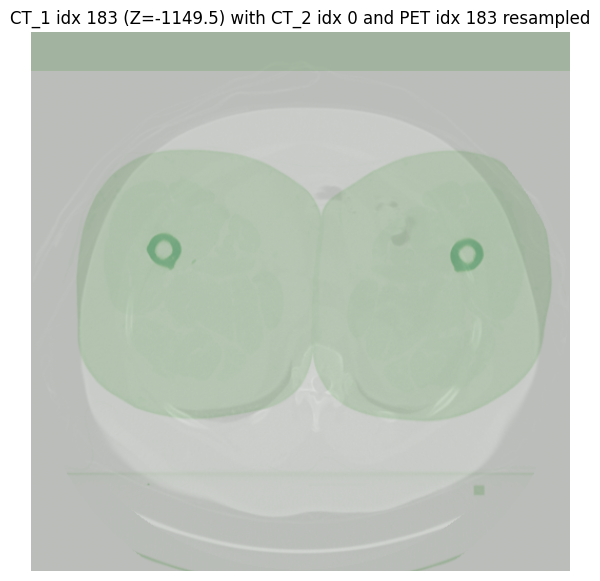

In [47]:
# ...existing code...
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

def read_slice_and_meta(df, idx):
    ds = pydicom.dcmread(df.iloc[idx]['filepath'], force=True)
    arr = ds.pixel_array.astype(float) * float(ds.get('RescaleSlope', 1.0)) + float(ds.get('RescaleIntercept', 0.0))
    ipp = np.array([float(x) for x in ds.ImagePositionPatient], dtype=float)
    ps = [float(x) for x in ds.get('PixelSpacing', [1.0,1.0])]
    iop = [float(x) for x in ds.get('ImageOrientationPatient', [1,0,0,0,1,0])]
    row_cos = np.array(iop[0:3], dtype=float)
    col_cos = np.array(iop[3:6], dtype=float)
    rows, cols = arr.shape
    meta = dict(ipp=ipp, ps=ps, iop=iop, row_cos=row_cos, col_cos=col_cos, rows=rows, cols=cols)
    return arr, meta

def find_slice_by_z(df, target_z):
    zs = []
    for i in range(len(df)):
        ds = pydicom.dcmread(df.iloc[i]['filepath'], stop_before_pixels=True, force=True)
        ipp = np.array([float(x) for x in ds.ImagePositionPatient], dtype=float)
        zs.append(ipp[2])
    zs = np.array(zs)
    idx = int(np.argmin(np.abs(zs - target_z)))
    return idx, zs[idx]

def resample_slice_to_target(src_arr, src_meta, target_meta, order=1):
    rows_t, cols_t = target_meta['rows'], target_meta['cols']
    rr = np.arange(rows_t); cc = np.arange(cols_t)
    grid_r, grid_c = np.meshgrid(rr, cc, indexing='ij')
    # target pixel centers in patient space
    pts = (target_meta['ipp'].reshape(1,1,3) +
           grid_c[:,:,None] * target_meta['row_cos'].reshape(1,1,3) * target_meta['ps'][1] +
           grid_r[:,:,None] * target_meta['col_cos'].reshape(1,1,3) * target_meta['ps'][0])
    # vector from source origin to those pts
    diff = pts - src_meta['ipp'].reshape(1,1,3)
    # project into source continuous indices
    col_src = np.tensordot(diff, src_meta['row_cos'], axes=([2],[0])) / src_meta['ps'][1]
    row_src = np.tensordot(diff, src_meta['col_cos'], axes=([2],[0])) / src_meta['ps'][0]
    coords = np.vstack([row_src.ravel(), col_src.ravel()])
    sampled = map_coordinates(src_arr, coords, order=order, mode='constant', cval=0.0)
    return sampled.reshape(rows_t, cols_t)

# --- Select CT_1 target slice (by index or specify) ---
ct1_idx = CT_1.shape[2] // 2
ct1_arr, ct1_meta = read_slice_and_meta(df_ct_orig, ct1_idx)
print(f"CT_1 target idx {ct1_idx}, Z = {ct1_meta['ipp'][2]:.2f}")

# --- Find matching CT_2 slice by Z and resample to CT_1 grid ---
ct1_z = ct1_meta['ipp'][2]
ct2_idx, ct2_z = find_slice_by_z(df_ct_plan, ct1_z)
ct2_arr, ct2_meta = read_slice_and_meta(df_ct_plan, ct2_idx)
print(f"Matched CT_2 idx {ct2_idx}, Z = {ct2_z:.2f} ; resampling CT_2 -> CT_1 grid")
ct2_on_ct1 = resample_slice_to_target(ct2_arr, ct2_meta, ct1_meta, order=1)

# --- Find matching PET slice by Z and resample to CT_1 grid ---
pet_idx, pet_z = find_slice_by_z(df_pet, ct1_z)
pet_arr, pet_meta = read_slice_and_meta(df_pet, pet_idx)
print(f"Matched PET idx {pet_idx}, Z = {pet_z:.2f} ; resampling PET -> CT_1 grid")
pet_on_ct1 = resample_slice_to_target(pet_arr, pet_meta, ct1_meta, order=1)

# --- Prepare display normalizations ---
def ct_window_display(a, vmin=-1000, vmax=3000):
    return np.clip((a - vmin) / (vmax - vmin), 0, 1)

def pet_norm_for_display(a):
    nz = a[a > 1e-6]
    if nz.size:
        pmin = np.percentile(nz, 5); pmax = np.percentile(nz, 99.8)
        if pmax <= pmin: pmin, pmax = nz.min(), nz.max() if nz.max()>nz.min() else (nz.min(), nz.min()+1.0)
        return np.clip((a - pmin) / (pmax - pmin), 0, 1)
    mn, mx = a.min(), a.max()
    return (a - mn) / (mx - mn) if mx != mn else np.zeros_like(a)

ct1_disp = ct_window_display(ct1_arr)
ct2_disp = ct_window_display(ct2_on_ct1)
pet_disp = pet_norm_for_display(pet_on_ct1)

# --- Figure: CT_1 base, CT_2 overlay (green), PET overlay (hot) ---
plt.figure(figsize=(7,7))
plt.imshow(ct1_disp, cmap='gray', alpha = 0.5, vmin=0, vmax=1)
plt.imshow(ct2_disp, cmap='Greens', alpha=0.5, vmin=0, vmax=1)
plt.imshow(pet_disp, cmap='hot', alpha=0, vmin=0, vmax=1)
plt.title(f'CT_1 idx {ct1_idx} (Z={ct1_meta["ipp"][2]:.1f}) with CT_2 idx {ct2_idx} and PET idx {pet_idx} resampled')
plt.axis('off')
plt.show()
# ...existing code...

Reading volumes...
Resampling to 5mm isotropic...
CT1 iso: shape=(100, 100, 220), spacing=[5. 5. 5.], FoR=1.2.246.352...., IOP=[1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
CT2 iso: shape=(100, 100, 95), spacing=[5. 5. 5.], FoR=1.2.246.352...., IOP=[1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
PET iso: shape=(145, 145, 220), spacing=[5. 5. 5.], FoR=1.2.246.352...., IOP=[1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Align PET via DICOM affine...

Estimating CT2→CT1 translation by phase correlation...
 - common crop: (np.int64(100), np.int64(100), np.int64(95)), shift (rows, cols, slices): [-4.0, 1.25, 0.0], error=1.00000
 - embed start: [0, 0, 62], CT2_aligned nonzero: 2200000, min/max: -1024.0/1456.6

Showing slice 100


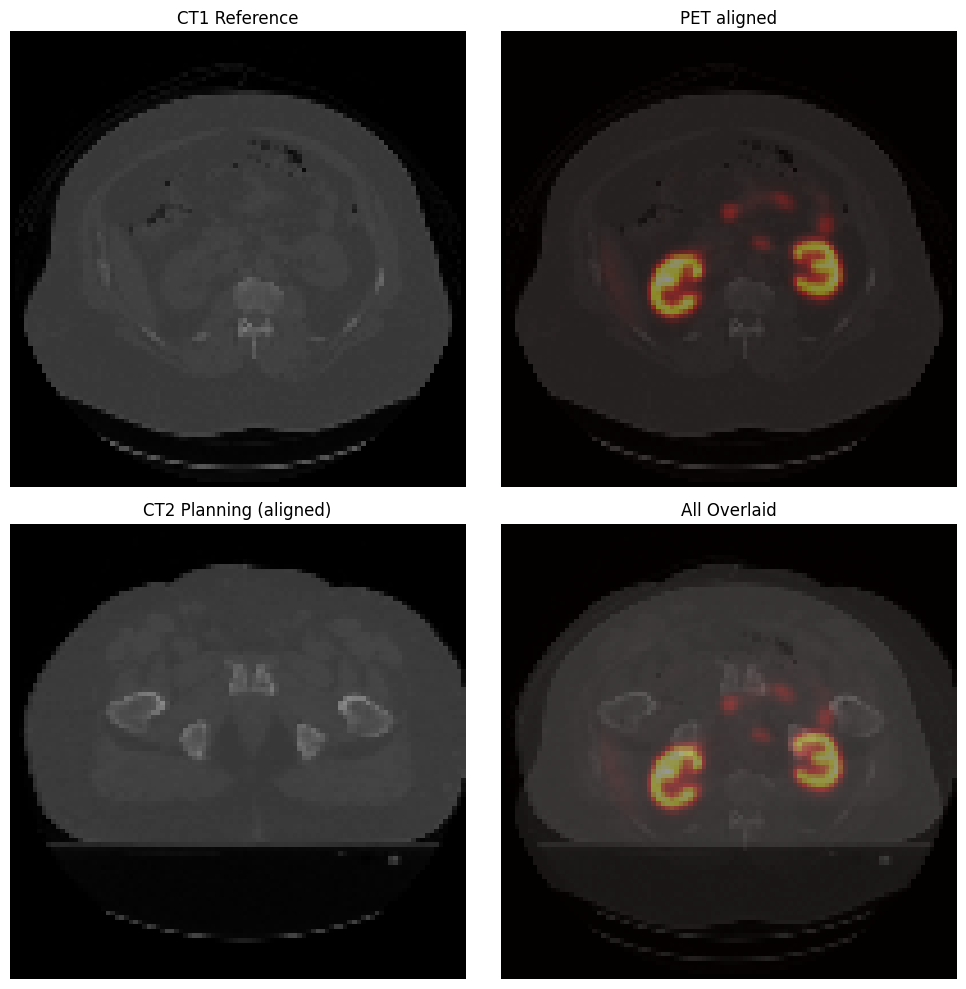


Showing slice 110


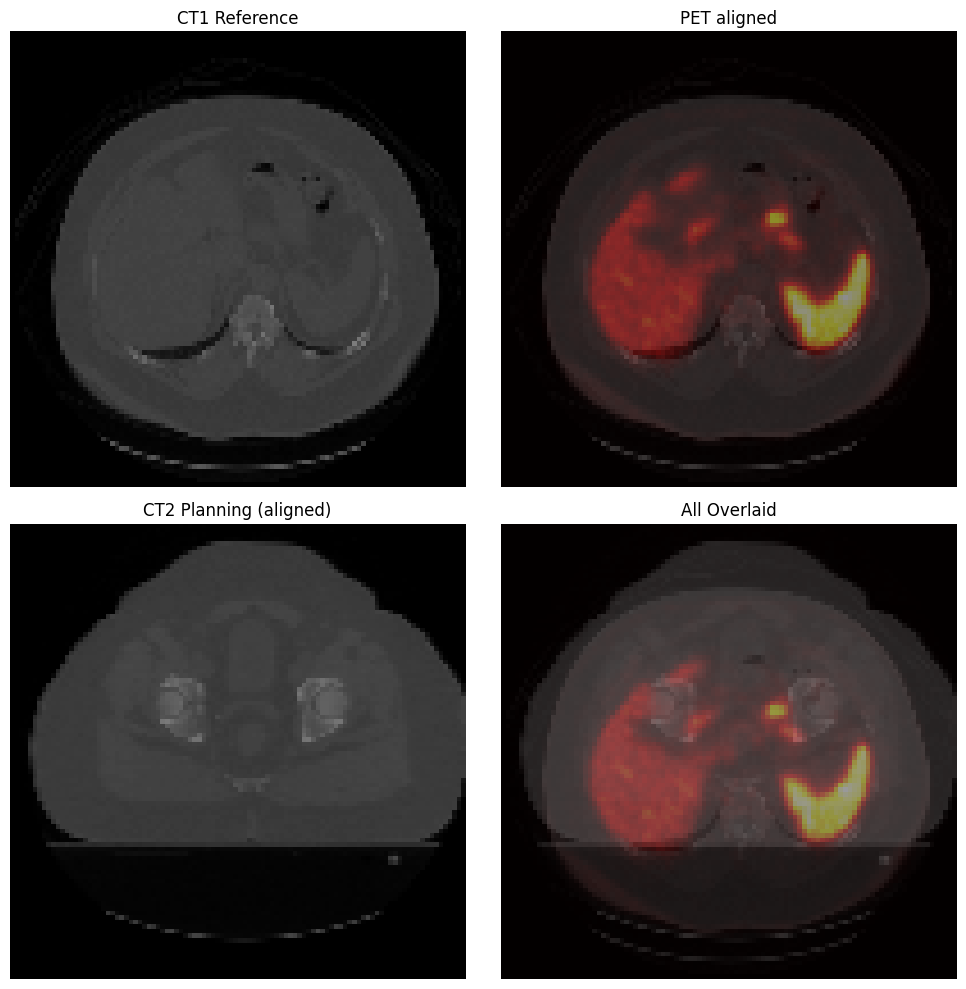


Showing slice 120


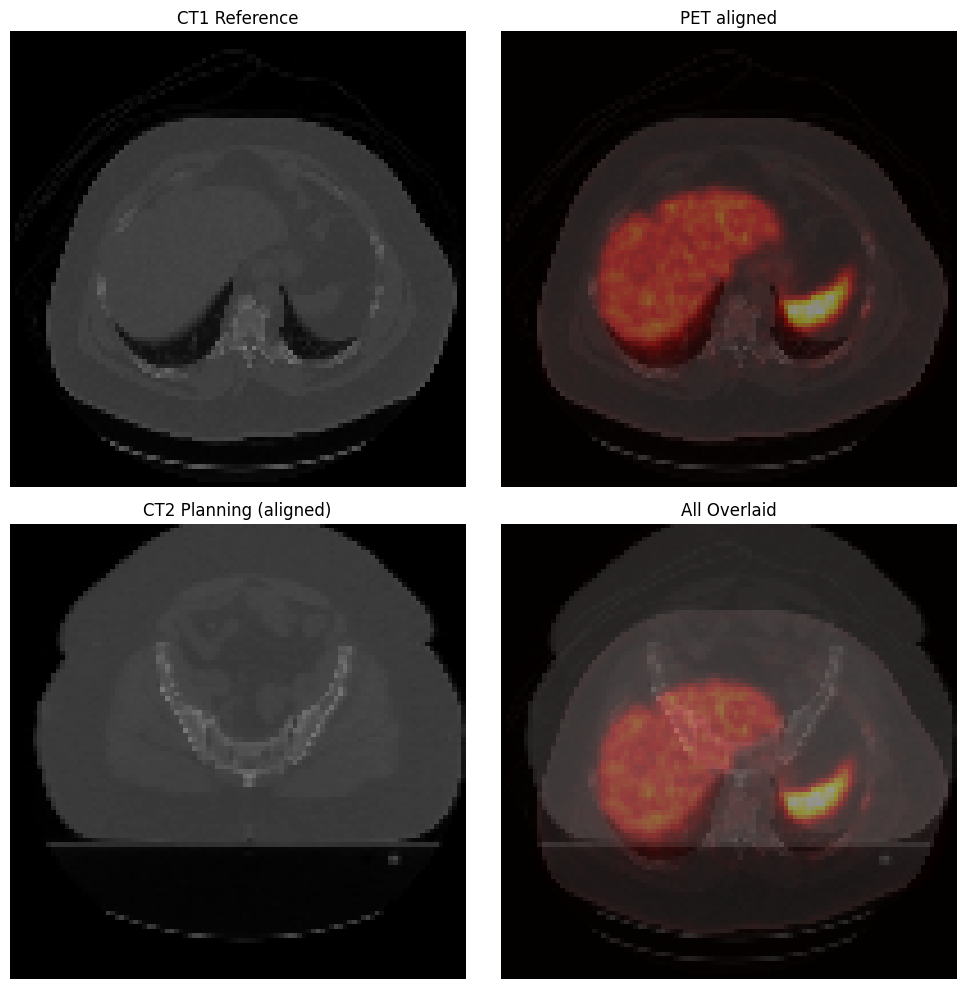


--- CT1 (isotropic) Metadata ---
Shape: (100, 100, 220)
Spacing: [5.0, 5.0, 5.0]
Origin: [-249.512, -473.012, -1698.5]
Orientation: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Dimensions: [100, 100, 220]
Min/Max voxel value: -1024.00 / 2070.24
Mean voxel value: -592.04
Nonzero count: 2200000
----------------------

--- CT2 (aligned) Metadata ---
Shape: (100, 100, 220)
Spacing: [5.0, 5.0, 5.0]
Origin: [-249.512, -473.012, -1698.5]
Orientation: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Dimensions: [100, 100, 220]
Min/Max voxel value: -1024.00 / 1456.60
Mean voxel value: -790.26
Nonzero count: 2200000
----------------------

--- PET (aligned) Metadata ---
Shape: (100, 100, 220)
Spacing: [5.0, 5.0, 5.0]
Origin: [-249.512, -473.012, -1698.5]
Orientation: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Dimensions: [100, 100, 220]
Min/Max voxel value: 0.00 / 58333.88
Mean voxel value: 246.58
Nonzero count: 2144928
----------------------


In [48]:
# ...existing code...
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates, zoom, shift as ndi_shift, gaussian_filter

# ---------- utilities ----------
def _safe_float_list(val, default):
    try:
        return [float(x) for x in val]
    except Exception:
        return default

def _slice_dir_from_iop(iop):
    row = np.array(iop[0:3], dtype=float)
    col = np.array(iop[3:6], dtype=float)
    slc = np.cross(row, col)
    # normalize
    for v in (row, col, slc):
        n = np.linalg.norm(v)
        if n > 0: v /= n
    return row, col, slc

def _compute_slice_positions_along_normal(df_sorted, iop):
    row, col, slc = _slice_dir_from_iop(iop)
    svals = []
    for i in range(len(df_sorted)):
        ds = pydicom.dcmread(df_sorted.iloc[i]['filepath'], stop_before_pixels=True, force=True)
        ipp = np.array(_safe_float_list(ds.get('ImagePositionPatient', [0,0,0]), [0,0,0]), dtype=float)
        svals.append(float(np.dot(ipp, slc)))
    return np.array(svals), slc

def get_volume_metadata(df_sorted):
    first_ds = pydicom.dcmread(df_sorted.iloc[0]['filepath'], stop_before_pixels=True, force=True)
    iop = _safe_float_list(first_ds.get('ImageOrientationPatient', [1,0,0,0,1,0]), [1,0,0,0,1,0])
    ps = _safe_float_list(first_ds.get('PixelSpacing', [1.0, 1.0]), [1.0, 1.0])
    ipp = np.array(_safe_float_list(first_ds.get('ImagePositionPatient', [0,0,0]), [0,0,0]), dtype=float)
    svals, _ = _compute_slice_positions_along_normal(df_sorted, iop)
    if len(svals) > 1:
        diffs = np.diff(svals)
        slice_spacing = float(np.median(np.abs(diffs)))
        if slice_spacing <= 0 or not np.isfinite(slice_spacing):
            slice_spacing = float(getattr(first_ds, 'SliceThickness', 1.0))
    else:
        slice_spacing = float(getattr(first_ds, 'SliceThickness', 1.0))
    return {
        'spacing': [float(ps[0]), float(ps[1]), float(slice_spacing)],
        'origin': ipp.astype(float),
        'orientation': [float(x) for x in iop],
        'dimensions': [int(first_ds.Rows), int(first_ds.Columns), int(len(df_sorted))],
        'for_uid': str(first_ds.get('FrameOfReferenceUID', ''))
    }

def read_volume_and_metadata(df_sorted):
    meta = get_volume_metadata(df_sorted)
    rows, cols, depth = meta['dimensions']
    vol = np.zeros((rows, cols, depth), dtype=np.float32)
    for i in range(depth):
        ds = pydicom.dcmread(df_sorted.iloc[i]['filepath'], force=True)
        arr = ds.pixel_array.astype(np.float32)
        slope = float(ds.get('RescaleSlope', 1.0))
        intercept = float(ds.get('RescaleIntercept', 0.0))
        vol[:, :, i] = arr * slope + intercept
    return vol, meta

def _affine_from_meta(meta):
    ps = meta['spacing']
    iop = meta['orientation']
    row, col, slc = _slice_dir_from_iop(iop)
    # Columns of M correspond to increments in (r,c,k)
    M = np.column_stack([
        col * float(ps[0]),  # r step (rows follow col cosine in DICOM)
        row * float(ps[1]),  # c step
        slc * float(ps[2])   # k step
    ])
    origin = np.array(meta['origin'], dtype=float)
    return M, origin

def _resample_via_affine(src_vol, src_meta, ref_meta, order=1, cval=0.0):
    R, C, K = ref_meta['dimensions']
    M_src, O_src = _affine_from_meta(src_meta)
    M_ref, O_ref = _affine_from_meta(ref_meta)
    rr = np.arange(R, dtype=np.float32)
    cc = np.arange(C, dtype=np.float32)
    kk = np.arange(K, dtype=np.float32)
    gr, gc, gk = np.meshgrid(rr, cc, kk, indexing='ij')  # (R,C,K)
    idx_stack = np.stack([gr.ravel(), gc.ravel(), gk.ravel()], axis=0)  # (3,N)
    P = O_ref.reshape(3,1) + M_ref @ idx_stack
    Minv = np.linalg.inv(M_src)
    src_idx = Minv @ (P - O_src.reshape(3,1))
    r_src = src_idx[0, :].reshape(R, C, K)
    c_src = src_idx[1, :].reshape(R, C, K)
    k_src = src_idx[2, :].reshape(R, C, K)
    coords = np.stack([r_src, c_src, k_src], axis=0)
    return map_coordinates(src_vol, coords, order=order, mode='constant', cval=cval).astype(np.float32)

def resample_to_isotropic(vol, orig_meta, target_spacing=5.0, order=1):
    s = [float(x) for x in orig_meta['spacing']]
    scale = [s[0]/target_spacing, s[1]/target_spacing, s[2]/target_spacing]
    new_dims = [int(round(vol.shape[0]*scale[0])),
                int(round(vol.shape[1]*scale[1])),
                int(round(vol.shape[2]*scale[2]))]
    cr = np.linspace(0, vol.shape[0]-1, new_dims[0], dtype=np.float32)
    cc = np.linspace(0, vol.shape[1]-1, new_dims[1], dtype=np.float32)
    ck = np.linspace(0, vol.shape[2]-1, new_dims[2], dtype=np.float32)
    gr, gc, gk = np.meshgrid(cr, cc, ck, indexing='ij')
    coords = np.stack([gr, gc, gk], axis=0)
    out = map_coordinates(vol, coords, order=order, mode='constant', cval=-1024.0).astype(np.float32)
    new_meta = dict(orig_meta)
    new_meta['spacing'] = [float(target_spacing)]*3
    new_meta['dimensions'] = [int(x) for x in new_dims]
    return out, new_meta

def _normalize_ct_for_cc(v, vmin=-1000, vmax=1500):
    v = np.clip(v, vmin, vmax).astype(np.float32)
    v = (v - vmin) / max(1e-6, (vmax - vmin))
    return gaussian_filter(v, sigma=1.0)

def _center_crop_to(vol, target_shape):
    out = np.zeros(target_shape, dtype=vol.dtype)
    src_s = [max(0, (vol.shape[i]-target_shape[i])//2) for i in range(3)]
    src_e = [src_s[i]+min(vol.shape[i], target_shape[i]) for i in range(3)]
    dst_s = [max(0, (target_shape[i]-vol.shape[i])//2) for i in range(3)]
    dst_e = [dst_s[i] + (src_e[i]-src_s[i]) for i in range(3)]
    out[dst_s[0]:dst_e[0], dst_s[1]:dst_e[1], dst_s[2]:dst_e[2]] = vol[src_s[0]:src_e[0], src_s[1]:src_e[1], src_s[2]:src_e[2]]
    return out

def _center_embed(vol, target_shape, cval=-1024.0):
    out = np.full(target_shape, cval, dtype=np.float32)
    start = [(target_shape[i]-vol.shape[i])//2 for i in range(3)]
    end = [start[i]+vol.shape[i] for i in range(3)]
    out[start[0]:end[0], start[1]:end[1], start[2]:end[2]] = vol
    return out, np.array(start, dtype=np.int32)

def _phase_shift_3d(ref, mov, upsample=4):
    try:
        from skimage.registration import phase_cross_correlation
    except Exception:
        raise RuntimeError("Install scikit-image: pip install scikit-image")
    shift, error, _ = phase_cross_correlation(ref, mov, upsample_factor=upsample)
    return shift.astype(np.float32), float(error)

def _apply_translation(vol, shift_vox, cval=-1024.0):
    # phase_cross_correlation returns shift (mov -> ref) in (y, x, z) for our (rows, cols, slices)
    return ndi_shift(vol, shift=shift_vox, order=1, mode='constant', cval=cval, prefilter=True).astype(np.float32)

def print_meta_quick(name, meta, vol):
    print(f"{name}: shape={tuple(vol.shape)}, spacing={np.round(meta['spacing'],3)}, FoR={meta.get('for_uid','')[:12]}..., "
          f"IOP={np.round(np.array(meta['orientation']),3).tolist()}")

# ---------- build volumes from your sorted DataFrames ----------
if 'df_ct_orig' not in globals() or 'df_ct_plan' not in globals() or 'df_pet' not in globals():
    raise RuntimeError("DataFrames df_ct_orig, df_ct_plan, df_pet not found. Run earlier binning/sorting cells first.")

print("Reading volumes...")
ct1_vol, ct1_meta = read_volume_and_metadata(df_ct_orig)
ct2_vol, ct2_meta = read_volume_and_metadata(df_ct_plan)
pet_vol, pet_meta = read_volume_and_metadata(df_pet)

print("Resampling to 5mm isotropic...")
ct1_iso, ct1_iso_meta = resample_to_isotropic(ct1_vol, ct1_meta, 5.0)
ct2_iso, ct2_iso_meta = resample_to_isotropic(ct2_vol, ct2_meta, 5.0)
pet_iso, pet_iso_meta = resample_to_isotropic(pet_vol, pet_meta, 5.0)

print_meta_quick("CT1 iso", ct1_iso_meta, ct1_iso)
print_meta_quick("CT2 iso", ct2_iso_meta, ct2_iso)
print_meta_quick("PET iso", pet_iso_meta, pet_iso)

# ---------- PET -> CT1 via DICOM affine if possible ----------
same_for_pet = (pet_iso_meta.get('for_uid','') != '' and pet_iso_meta.get('for_uid') == ct1_iso_meta.get('for_uid'))
iop_close_pet = np.allclose(np.array(pet_iso_meta['orientation'],float), np.array(ct1_iso_meta['orientation'],float), atol=1e-3)
if same_for_pet and iop_close_pet:
    print("Align PET via DICOM affine...")
    pet_aligned = _resample_via_affine(pet_iso, pet_iso_meta, ct1_iso_meta, order=1, cval=0.0)
else:
    print("PET FoR/IOP mismatch; center-embed to CT1 dims.")
    pet_aligned, _ = _center_embed(pet_iso, ct1_iso.shape, cval=0.0)

# ---------- CT2 -> CT1 using image-based translation (ignoring DICOM origins) ----------
print("\nEstimating CT2→CT1 translation by phase correlation...")
# equal-size crops for correlation
common_shape = tuple(np.minimum(ct1_iso.shape, ct2_iso.shape))
ct1_crop = _center_crop_to(_normalize_ct_for_cc(ct1_iso), common_shape)
ct2_crop = _center_crop_to(_normalize_ct_for_cc(ct2_iso), common_shape)

try:
    shift_crop, err = _phase_shift_3d(ct1_crop, ct2_crop, upsample=4)
except RuntimeError as e:
    print(str(e))
    # Optional: auto-install in notebooks
    # !pip install -q scikit-image
    raise

print(f" - common crop: {common_shape}, shift (rows, cols, slices): {shift_crop.tolist()}, error={err:.5f}")

# embed CT2 into CT1 grid then apply shift
ct2_on_ct1, embed_start = _center_embed(ct2_iso, ct1_iso.shape, cval=-1024.0)
ct2_aligned = _apply_translation(ct2_on_ct1, shift_crop, cval=-1024.0)

print(f" - embed start: {embed_start.tolist()}, CT2_aligned nonzero: {int(np.count_nonzero(ct2_aligned))}, "
      f"min/max: {ct2_aligned.min():.1f}/{ct2_aligned.max():.1f}")

# Extra sanity: if still near-constant, reduce smoothing and retry 2D-by-2D
if np.count_nonzero(np.abs(ct2_aligned + 1024.0) > 5) < 100:
    print(" - Warning: CT2 still looks empty post-shift. Trying 2D per-slice correlation around mid-slice...")
    mid = ct1_iso.shape[2]//2
    from skimage.registration import phase_cross_correlation
    ref2d = _normalize_ct_for_cc(ct1_iso[:,:,mid])
    mov2d = _normalize_ct_for_cc(_center_crop_to(ct2_iso, common_shape)[:,:,common_shape[2]//2])
    s2d, _, _ = phase_cross_correlation(ref2d, mov2d, upsample_factor=8)
    print(f" - 2D mid-slice shift: {s2d.tolist()}")
    # apply 2D-only shift to each slice (x,y) while keeping previous z shift
    per_slice = np.zeros(3, dtype=np.float32); per_slice[:2] = s2d[:2]; per_slice[2] = shift_crop[2]
    ct2_aligned = _apply_translation(ct2_on_ct1, per_slice, cval=-1024.0)
    print(f" - After 2D correction, nonzero: {int(np.count_nonzero(ct2_aligned))}")

# ---------- display ----------
def display_alignment_quartet(ct1, ct2, pet, slice_idx):
    plt.figure(figsize=(10,10))
    plt.subplot(221); plt.imshow(ct1[:,:,slice_idx], cmap='gray', vmin=-1000, vmax=3000); plt.title('CT1 Reference'); plt.axis('off')
    plt.subplot(222); plt.imshow(ct1[:,:,slice_idx], cmap='gray', vmin=-1000, vmax=3000); plt.imshow(pet[:,:,slice_idx], cmap='hot', alpha=0.4); plt.title('PET aligned'); plt.axis('off')
    plt.subplot(223); plt.imshow(ct2[:,:,slice_idx], cmap='gray', vmin=-1000, vmax=3000); plt.title('CT2 Planning (aligned)'); plt.axis('off')
    plt.subplot(224); plt.imshow(ct1[:,:,slice_idx], cmap='gray', vmin=-1000, vmax=3000); plt.imshow(ct2[:,:,slice_idx], cmap='gray', alpha=0.45); plt.imshow(pet[:,:,slice_idx], cmap='hot', alpha=0.35); plt.title('All Overlaid'); plt.axis('off')
    plt.tight_layout(); plt.show()

slices_to_show = [ct1_iso.shape[2]//2-10, ct1_iso.shape[2]//2, ct1_iso.shape[2]//2+10]
for s in slices_to_show:
    print(f"\nShowing slice {s}")
    display_alignment_quartet(ct1_iso, ct2_aligned, pet_aligned, s)

# ---------- final metadata summary ----------
def print_volume_metadata(name, meta, vol):
    print(f"\n--- {name} Metadata ---")
    print(f"Shape: {tuple(vol.shape)}")
    print(f"Spacing: {meta.get('spacing')}")
    print(f"Origin: {np.array(meta.get('origin')).round(3).tolist()}")
    print(f"Orientation: {np.array(meta.get('orientation')).round(3).tolist()}")
    print(f"Dimensions: {meta.get('dimensions')}")
    print(f"Min/Max voxel value: {float(np.min(vol)):.2f} / {float(np.max(vol)):.2f}")
    print(f"Mean voxel value: {float(np.mean(vol)):.2f}")
    print(f"Nonzero count: {int(np.count_nonzero(vol))}")
    print("----------------------")

print_volume_metadata("CT1 (isotropic)", ct1_iso_meta, ct1_iso)
print_volume_metadata("CT2 (aligned)", ct1_iso_meta, ct2_aligned)
print_volume_metadata("PET (aligned)", ct1_iso_meta, pet_aligned)
# ...existing code...

In [49]:
# New cell: geometry diagnostics + overlap analysis (use isotropic volumes/metas already built)
import numpy as np, pydicom

def _slice_dir_from_iop(iop):
    row = np.array(iop[0:3], dtype=float)
    col = np.array(iop[3:6], dtype=float)
    slc = np.cross(row, col)
    for v in (row, col, slc):
        n = np.linalg.norm(v)
        if n > 0: v /= n
    return row, col, slc

def _affine_from_meta(meta):
    ps = meta['spacing']; iop = meta['orientation']
    row, col, slc = _slice_dir_from_iop(iop)
    M = np.column_stack([col*float(ps[0]), row*float(ps[1]), slc*float(ps[2])])  # idx=[r,c,k]
    O = np.array(meta['origin'], dtype=float)
    return M, O, row, col, slc

def _geom_from(vol, meta):
    R,C,K = vol.shape
    M,O,row,col,slc = _affine_from_meta(meta)
    # 8-corner bbox in patient coords
    corners_idx = np.array(np.meshgrid([0,R-1],[0,C-1],[0,K-1], indexing='ij')).reshape(3,-1)  # (3,8)
    corners_xyz = O.reshape(3,1) + M @ corners_idx
    bb_min = corners_xyz.min(axis=1); bb_max = corners_xyz.max(axis=1); center = corners_xyz.mean(axis=1)
    # s-position along slice normal for each k index
    k_idx = np.arange(K, dtype=float)
    svals = np.dot((O + slc*meta['spacing'][2]*k_idx[:,None]), slc).ravel()
    return dict(R=R,C=C,K=K,spacing=np.array(meta['spacing'],float),
                iop=np.array(meta['orientation'],float),
                row=row,col=col,slc=slc, M=M, O=O,
                bb_min=bb_min, bb_max=bb_max, center=center,
                svals=svals, for_uid=str(meta.get('for_uid','')))

def _angle_deg(a,b):
    a = a/np.linalg.norm(a); b = b/np.linalg.norm(b)
    d = float(np.clip(np.dot(a,b), -1, 1))
    return float(np.degrees(np.arccos(d)))

def _interval_overlap(a0, a1, b0, b1):
    lo, hi = max(min(a0,a1), min(b0,b1)), min(max(a0,a1), max(b0,b1))
    return max(0.0, hi-lo), lo, hi

ct1G = _geom_from(ct1_iso, ct1_iso_meta)
ct2G = _geom_from(ct2_iso, ct2_iso_meta)
petG = _geom_from(pet_iso, pet_iso_meta)

def _print_geom(name,g):
    xy_mm = [g['C']*g['spacing'][1], g['R']*g['spacing'][0]]
    smin, smax = float(g['svals'].min()), float(g['svals'].max())
    dz = np.median(np.diff(g['svals'])) if g['svals'].size>1 else np.nan
    order = "increasing" if (np.nan_to_num(dz) >= 0) else "decreasing"
    print(f"\n{name}: shape={g['R'],g['C'],g['K']} spacing={np.round(g['spacing'],3).tolist()} FoR={g['for_uid'][:16]}...")
    print(f"  IOP row={np.round(g['row'],3)}, col={np.round(g['col'],3)}, normal={np.round(g['slc'],3)}")
    print(f"  XY FOV (mm) = {np.round(xy_mm,1).tolist()}  Z step≈{dz:.3f} mm, order={order}")
    print(f"  s-range along normal: [{smin:.1f}, {smax:.1f}] mm  (length {(smax-smin):.1f} mm)")
    print(f"  BBox min={np.round(g['bb_min'],1)}, max={np.round(g['bb_max'],1)}, center={np.round(g['center'],1)}")

_print_geom("CT1 iso", ct1G)
_print_geom("CT2 iso", ct2G)
_print_geom("PET iso", petG)

print("\nOrientation deltas (deg):")
print(f"  CT1 vs CT2   -> row={_angle_deg(ct1G['row'],ct2G['row']):.2f}, col={_angle_deg(ct1G['col'],ct2G['col']):.2f}, normal={_angle_deg(ct1G['slc'],ct2G['slc']):.2f}")
print(f"  CT1 vs PET   -> row={_angle_deg(ct1G['row'],petG['row']):.2f}, col={_angle_deg(ct1G['col'],petG['col']):.2f}, normal={_angle_deg(ct1G['slc'],petG['slc']):.2f}")

print("\nSame FrameOfReferenceUID?")
print("  CT1-PET:", petG['for_uid']!='' and petG['for_uid']==ct1G['for_uid'])
print("  CT1-CT2:", ct2G['for_uid']!='' and ct2G['for_uid']==ct1G['for_uid'])

# Z-overlap (along CT1 normal) using the s-ranges we computed
len_z, z_lo, z_hi = _interval_overlap(ct1G['svals'].min(), ct1G['svals'].max(),
                                      ct2G['svals'].min(), ct2G['svals'].max())
print(f"\nCT1–CT2 z-overlap length: {len_z:.1f} mm (CT1={np.ptp(ct1G['svals']):.1f} mm, CT2={np.ptp(ct2G['svals']):.1f} mm)")
if len_z <= 5:
    print("  -> Little/no z-overlap: the shown CT1 slices likely cover different anatomy than CT2 (e.g., abdomen vs pelvis).")
else:
    # which CT1 slice indices are within the overlap window
    mask_ct1 = (ct1G['svals'] >= z_lo) & (ct1G['svals'] <= z_hi)
    idxs = np.where(mask_ct1)[0]
    print(f"  CT1 indices inside CT2 overlap: {len(idxs)} slices, representative:", idxs[[0, len(idxs)//2, -1]].tolist() if len(idxs)>2 else idxs.tolist())

# Optional XY bbox overlap check (rough, assumes nearly parallel orientations)
xy1 = np.stack([ct1G['bb_min'][:2], ct1G['bb_max'][:2]], axis=0)
xy2 = np.stack([ct2G['bb_min'][:2], ct2G['bb_max'][:2]], axis=0)
xy_overlap = np.maximum(0, np.minimum(xy1.max(0), xy2.max(0)) - np.maximum(xy1.min(0), xy2.min(0)))
print(f"\nApprox XY FOV overlap (mm): {np.round(xy_overlap,1)}")


CT1 iso: shape=(100, 100, 220) spacing=[5.0, 5.0, 5.0] FoR=1.2.246.352.221....
  IOP row=[1. 0. 0.], col=[0. 1. 0.], normal=[0. 0. 1.]
  XY FOV (mm) = [500.0, 500.0]  Z step≈5.000 mm, order=increasing
  s-range along normal: [-1698.5, -603.5] mm  (length 1095.0 mm)
  BBox min=[ -249.5  -473.  -1698.5], max=[ 245.5   22.  -603.5], center=[   -2.   -225.5 -1151. ]

CT2 iso: shape=(100, 100, 95) spacing=[5.0, 5.0, 5.0] FoR=1.2.246.352.221....
  IOP row=[1. 0. 0.], col=[0. 1. 0.], normal=[0. 0. 1.]
  XY FOV (mm) = [500.0, 500.0]  Z step≈5.000 mm, order=increasing
  s-range along normal: [-189.3, 280.7] mm  (length 470.0 mm)
  BBox min=[-249.5 -437.5 -189.3], max=[245.5  57.5 280.7], center=[  -2.  -190.    45.7]

PET iso: shape=(145, 145, 220) spacing=[5.0, 5.0, 5.0] FoR=1.2.246.352.221....
  IOP row=[1. 0. 0.], col=[0. 1. 0.], normal=[0. 0. 1.]
  XY FOV (mm) = [725.0, 725.0]  Z step≈5.000 mm, order=increasing
  s-range along normal: [-1698.5, -603.5] mm  (length 1095.0 mm)
  BBox min=[ -

Abort: CT1 and CT2 have 0 mm z-overlap and different FrameOfReferenceUIDs.
Provide a DICOM REG object or pick a CT series with overlapping coverage.


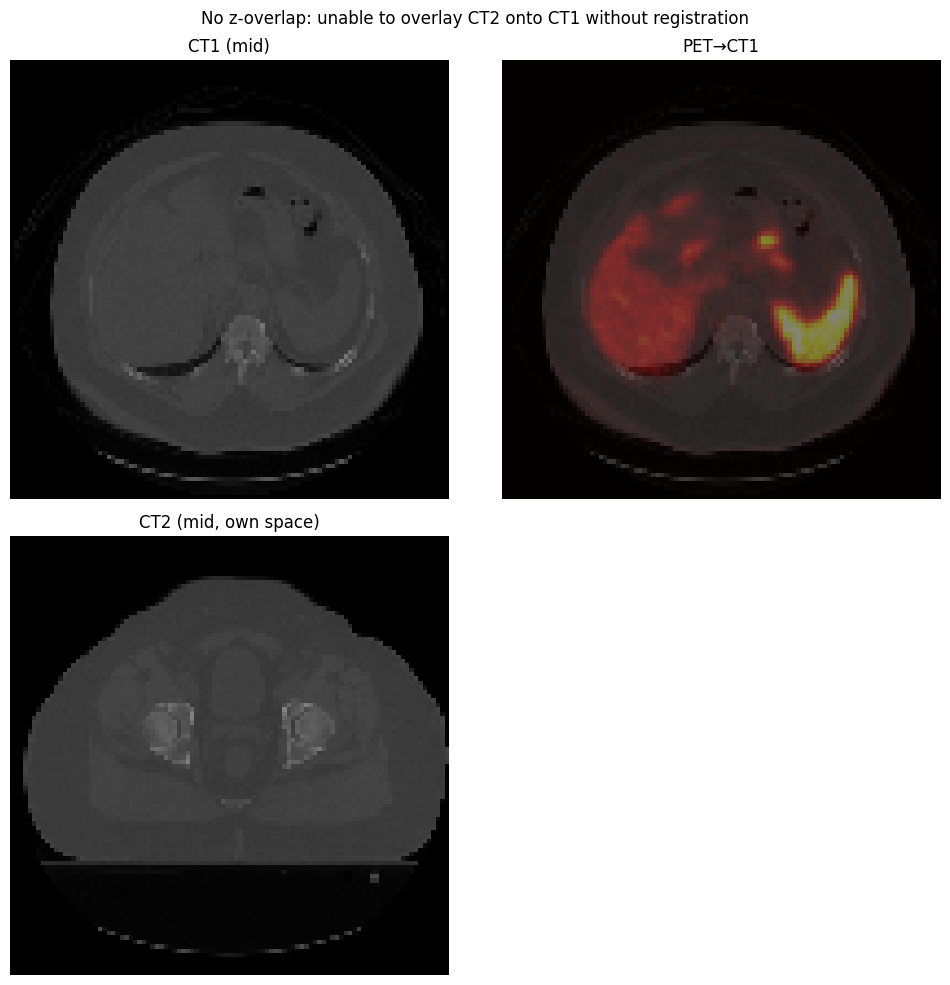

In [50]:
# Overlay manager: only performs a correct overlay when there is z-overlap in the same geometry.
# If there is no overlap or different FrameOfReference, it refuses (or optionally forces a best-effort alignment).
import numpy as np
import matplotlib.pyplot as plt

def overlay_ct2_on_ct1(ct1_iso, ct1G, ct1_iso_meta,
                       ct2_iso, ct2G, ct2_iso_meta,
                       pet_aligned=None,
                       angle_tol_deg=1.0,
                       force_best_effort=False):
    def _interval_overlap(a0,a1,b0,b1):
        lo, hi = max(min(a0,a1), min(b0,b1)), min(max(a0,a1), max(b0,b1))
        return max(0.0, hi-lo), lo, hi

    def _angle_deg(a,b):
        a = a/np.linalg.norm(a); b = b/np.linalg.norm(b)
        d = float(np.clip(np.dot(a,b), -1, 1))
        return float(np.degrees(np.arccos(d)))

    # Basic geometry checks
    same_for = (ct1G['for_uid'] != '' and ct2G['for_uid'] != '' and ct1G['for_uid'] == ct2G['for_uid'])
    ang_row = _angle_deg(ct1G['row'], ct2G['row'])
    ang_col = _angle_deg(ct1G['col'], ct2G['col'])
    ang_nrm = _angle_deg(ct1G['slc'], ct2G['slc'])
    Lz, zlo, zhi = _interval_overlap(ct1G['svals'].min(), ct1G['svals'].max(),
                                     ct2G['svals'].min(), ct2G['svals'].max())

    if (ang_row > angle_tol_deg or ang_col > angle_tol_deg or ang_nrm > angle_tol_deg):
        print(f"Abort: orientations differ too much (row {ang_row:.2f}, col {ang_col:.2f}, normal {ang_nrm:.2f} deg).")
        return None

    if Lz <= 0 and not force_best_effort:
        print("Abort: CT1 and CT2 have 0 mm z-overlap and different FrameOfReferenceUIDs.")
        print("Provide a DICOM REG object or pick a CT series with overlapping coverage.")
        # Show a quick figure so you still see each modality in its correct space
        mid1 = ct1_iso.shape[2]//2
        mid2 = ct2_iso.shape[2]//2
        plt.figure(figsize=(10,10))
        plt.subplot(221); plt.imshow(ct1_iso[:,:,mid1], cmap='gray', vmin=-1000, vmax=3000); plt.title('CT1 (mid)'); plt.axis('off')
        if pet_aligned is not None:
            plt.subplot(222); plt.imshow(ct1_iso[:,:,mid1], cmap='gray', vmin=-1000, vmax=3000); plt.imshow(pet_aligned[:,:,mid1], cmap='hot', alpha=0.35); plt.title('PET→CT1'); plt.axis('off')
        plt.subplot(223); plt.imshow(ct2_iso[:,:,mid2], cmap='gray', vmin=-1000, vmax=3000); plt.title('CT2 (mid, own space)'); plt.axis('off')
        plt.suptitle('No z-overlap: unable to overlay CT2 onto CT1 without registration')
        plt.tight_layout(); plt.show()
        return None

    # Case A: there is z-overlap -> do overlap-only registration and embed on CT1 grid
    if Lz > 0:
        from skimage.registration import phase_cross_correlation
        def _normalize_ct_for_cc(v, vmin=-1000, vmax=1500):
            from scipy.ndimage import gaussian_filter
            v = np.clip(v, vmin, vmax).astype(np.float32)
            v = (v - vmin) / max(1e-6, (vmax - vmin))
            return gaussian_filter(v, sigma=1.0)

        # indices in each volume that are inside the overlap window
        k1 = np.where((ct1G['svals']>=zlo) & (ct1G['svals']<=zhi))[0]
        k2 = np.where((ct2G['svals']>=zlo) & (ct2G['svals']<=zhi))[0]
        ct1_ov = ct1_iso[:, :, k1[0]:k1[-1]+1]
        ct2_ov = ct2_iso[:, :, k2[0]:k2[-1]+1]

        # equalize shapes for correlation
        common = tuple(np.minimum(ct1_ov.shape, ct2_ov.shape))
        def _center_crop_to(vol, target_shape):
            out = np.zeros(target_shape, dtype=vol.dtype)
            ss = [max(0, (vol.shape[i]-target_shape[i])//2) for i in range(3)]
            ee = [ss[i]+min(vol.shape[i], target_shape[i]) for i in range(3)]
            ds = [max(0, (target_shape[i]-vol.shape[i])//2) for i in range(3)]
            de = [ds[i] + (ee[i]-ss[i]) for i in range(3)]
            out[ds[0]:de[0], ds[1]:de[1], ds[2]:de[2]] = vol[ss[0]:ee[0], ss[1]:ee[1], ss[2]:ee[2]]
            return out
        ref = _center_crop_to(_normalize_ct_for_cc(ct1_ov), common)
        mov = _center_crop_to(_normalize_ct_for_cc(ct2_ov), common)

        shift_vox, err = phase_cross_correlation(ref, mov, upsample_factor=4)
        print(f"Overlap-only shift (rows, cols, slices): {shift_vox.tolist()}, error={err:.5f}")

        # embed CT2 into CT1 grid then apply the shift
        def _center_embed(vol, target_shape, cval=-1024.0):
            out = np.full(target_shape, cval, dtype=np.float32)
            start = [(target_shape[i]-vol.shape[i])//2 for i in range(3)]
            end = [start[i]+vol.shape[i] for i in range(3)]
            out[start[0]:end[0], start[1]:end[1], start[2]:end[2]] = vol
            return out, np.array(start, dtype=np.int32)

        def _apply_translation(vol, shift_vox, cval=-1024.0):
            from scipy.ndimage import shift as ndi_shift
            return ndi_shift(vol, shift=shift_vox, order=1, mode='constant', cval=cval, prefilter=True).astype(np.float32)

        ct2_on_ct1, _ = _center_embed(ct2_iso, ct1_iso.shape, cval=-1024.0)
        ct2_aligned = _apply_translation(ct2_on_ct1, shift_vox, cval=-1024.0)

        # visualize around overlap mid
        mid = int(np.round((k1[0] + k1[-1]) / 2))
        for s in [mid-5, mid, mid+5]:
            s = int(np.clip(s, 0, ct1_iso.shape[2]-1))
            plt.figure(figsize=(10,10))
            plt.subplot(221); plt.imshow(ct1_iso[:,:,s], cmap='gray', vmin=-1000, vmax=3000); plt.title('CT1'); plt.axis('off')
            if pet_aligned is not None:
                plt.subplot(222); plt.imshow(ct1_iso[:,:,s], cmap='gray', vmin=-1000, vmax=3000); plt.imshow(pet_aligned[:,:,s], cmap='hot', alpha=0.35); plt.title('PET→CT1'); plt.axis('off')
            plt.subplot(223); plt.imshow(ct2_aligned[:,:,s], cmap='gray', vmin=-1000, vmax=3000); plt.title('CT2 aligned'); plt.axis('off')
            plt.subplot(224); plt.imshow(ct1_iso[:,:,s], cmap='gray', vmin=-1000, vmax=3000); plt.imshow(ct2_aligned[:,:,s], cmap='gray', alpha=0.45); 
            if pet_aligned is not None: plt.imshow(pet_aligned[:,:,s], cmap='hot', alpha=0.30)
            plt.title('Overlay at overlapping z'); plt.axis('off'); plt.tight_layout(); plt.show()
        return ct2_aligned

    # Case B: no z-overlap -> optional best-effort (not geometrically valid)
    if force_best_effort:
        print("Warning: forcing intensity-only alignment. Result is NOT in real patient space.")
        # normalize for correlation, then estimate 3D shift over center-cropped slabs
        from skimage.registration import phase_cross_correlation
        def _normalize_ct_for_cc(v, vmin=-1000, vmax=1500):
            from scipy.ndimage import gaussian_filter
            v = np.clip(v, vmin, vmax).astype(np.float32)
            v = (v - vmin) / max(1e-6, (vmax - vmin))
            return gaussian_filter(v, sigma=1.0)
        common = tuple(np.minimum(ct1_iso.shape, ct2_iso.shape))
        def _center_crop_to(vol, target_shape):
            out = np.zeros(target_shape, dtype=vol.dtype)
            ss = [max(0, (vol.shape[i]-target_shape[i])//2) for i in range(3)]
            ee = [ss[i]+min(vol.shape[i], target_shape[i]) for i in range(3)]
            ds = [max(0, (target_shape[i]-vol.shape[i])//2) for i in range(3)]
            de = [ds[i] + (ee[i]-ss[i]) for i in range(3)]
            out[ds[0]:de[0], ds[1]:de[1], ds[2]:de[2]] = vol[ss[0]:ee[0], ss[1]:ee[1], ss[2]:ee[2]]
            return out
        ref = _center_crop_to(_normalize_ct_for_cc(ct1_iso), common)
        mov = _center_crop_to(_normalize_ct_for_cc(ct2_iso), common)
        shift_vox, err = phase_cross_correlation(ref, mov, upsample_factor=4)
        print(f"Forced shift (rows, cols, slices): {shift_vox.tolist()}, error={err:.5f}")

        from scipy.ndimage import shift as ndi_shift
        def _center_embed(vol, target_shape, cval=-1024.0):
            out = np.full(target_shape, cval, dtype=np.float32)
            start = [(target_shape[i]-vol.shape[i])//2 for i in range(3)]
            end = [start[i]+vol.shape[i] for i in range(3)]
            out[start[0]:end[0], start[1]:end[1], start[2]:end[2]] = vol
            return out

        ct2_on_ct1 = _center_embed(ct2_iso, ct1_iso.shape, cval=-1024.0)
        ct2_aligned = ndi_shift(ct2_on_ct1, shift=shift_vox, order=1, mode='constant', cval=-1024.0, prefilter=True).astype(np.float32)

        mid = ct1_iso.shape[2]//2
        plt.figure(figsize=(10,10))
        plt.subplot(221); plt.imshow(ct1_iso[:,:,mid], cmap='gray', vmin=-1000, vmax=3000); plt.title('CT1'); plt.axis('off')
        if pet_aligned is not None:
            plt.subplot(222); plt.imshow(ct1_iso[:,:,mid], cmap='gray', vmin=-1000, vmax=3000); plt.imshow(pet_aligned[:,:,mid], cmap='hot', alpha=0.35); plt.title('PET→CT1'); plt.axis('off')
        plt.subplot(223); plt.imshow(ct2_aligned[:,:,mid], cmap='gray', vmin=-1000, vmax=3000); plt.title('CT2 forced'); plt.axis('off')
        plt.subplot(224); plt.imshow(ct1_iso[:,:,mid], cmap='gray', vmin=-1000, vmax=3000); plt.imshow(ct2_aligned[:,:,mid], cmap='gray', alpha=0.45)
        if pet_aligned is not None: plt.imshow(pet_aligned[:,:,mid], cmap='hot', alpha=0.30)
        plt.title('Overlay (not anatomically valid)'); plt.axis('off'); plt.tight_layout(); plt.show()
        return ct2_aligned

    return None

# Run with your already-built isotropic volumes and geometry dicts (ct1G, ct2G, pet aligned earlier).
ct2_overlaid = overlay_ct2_on_ct1(ct1_iso, ct1G, ct1_iso_meta,
                                  ct2_iso, ct2G, ct2_iso_meta,
                                  pet_aligned=pet_aligned,
                                  angle_tol_deg=1.0,
                                  force_best_effort=False)  # set True only if you accept non-physical overlay

=== Bone-Driven CT2→CT1 Alignment ===

Extracting bone features...
  CT1 bone voxels: 15855 (0.7%)
  CT2 bone voxels: 7215 (0.8%)

Cropping to common shape: (np.int64(100), np.int64(100), np.int64(95))

Running phase cross-correlation (bone-masked)...
  Shift (rows, cols, slices): [14.0, -1.0, -53.0]
  Correlation error: nan
  Physical shift (mm @ 5mm spacing): [70.0, -5.0, -265.0]

Applying shift to CT2...
  Embedded at offset: [0, 0, 62]
  Aligned CT2 nonzero voxels: 520446 (23.7%)

=== Displaying Alignment Results ===


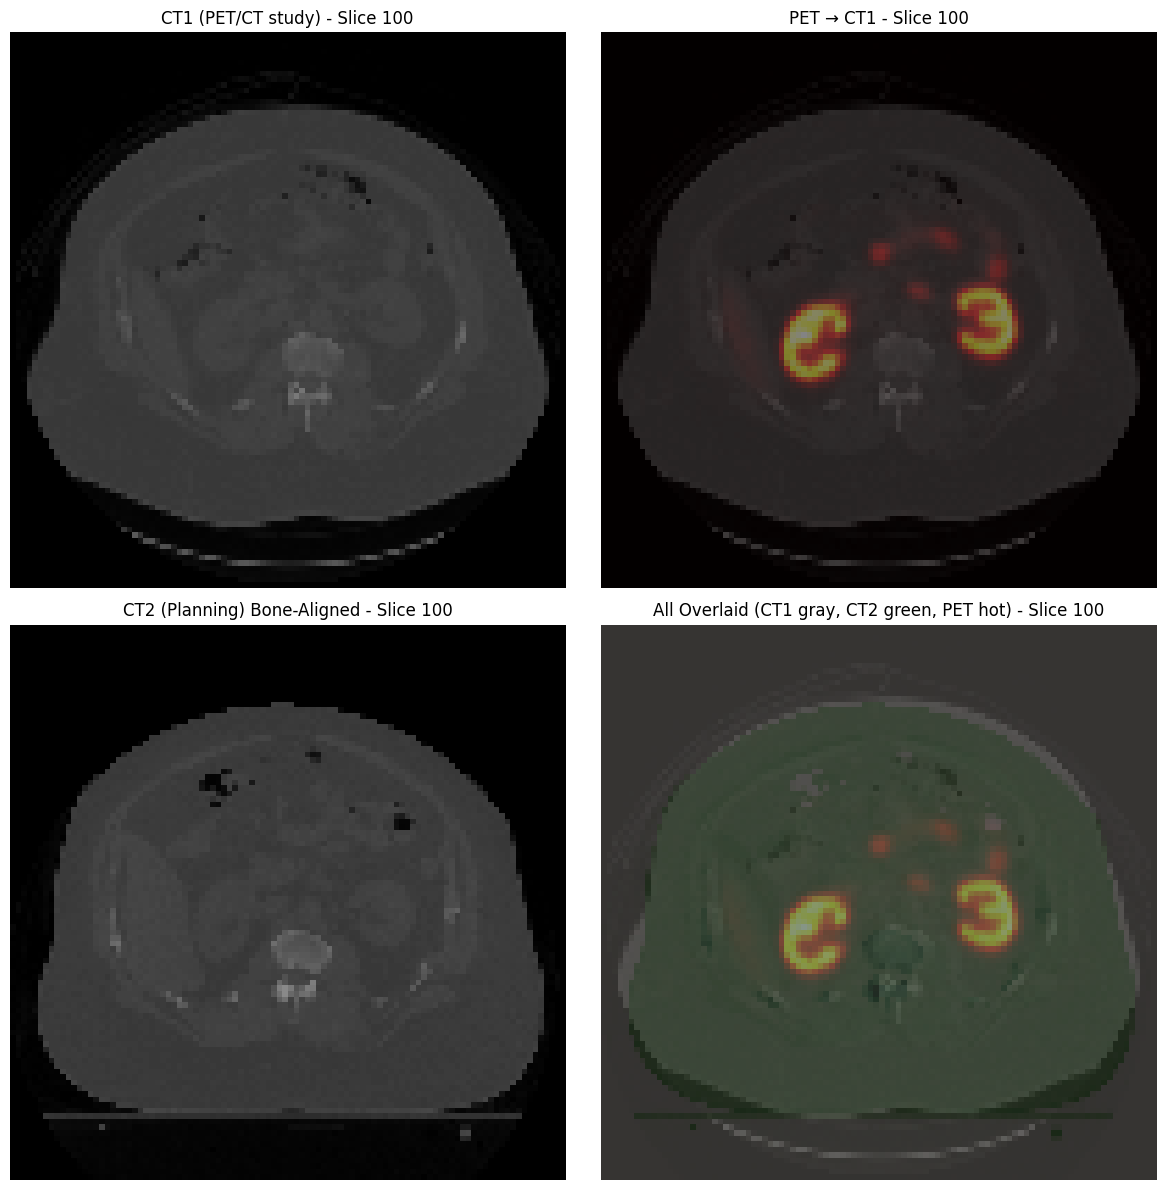

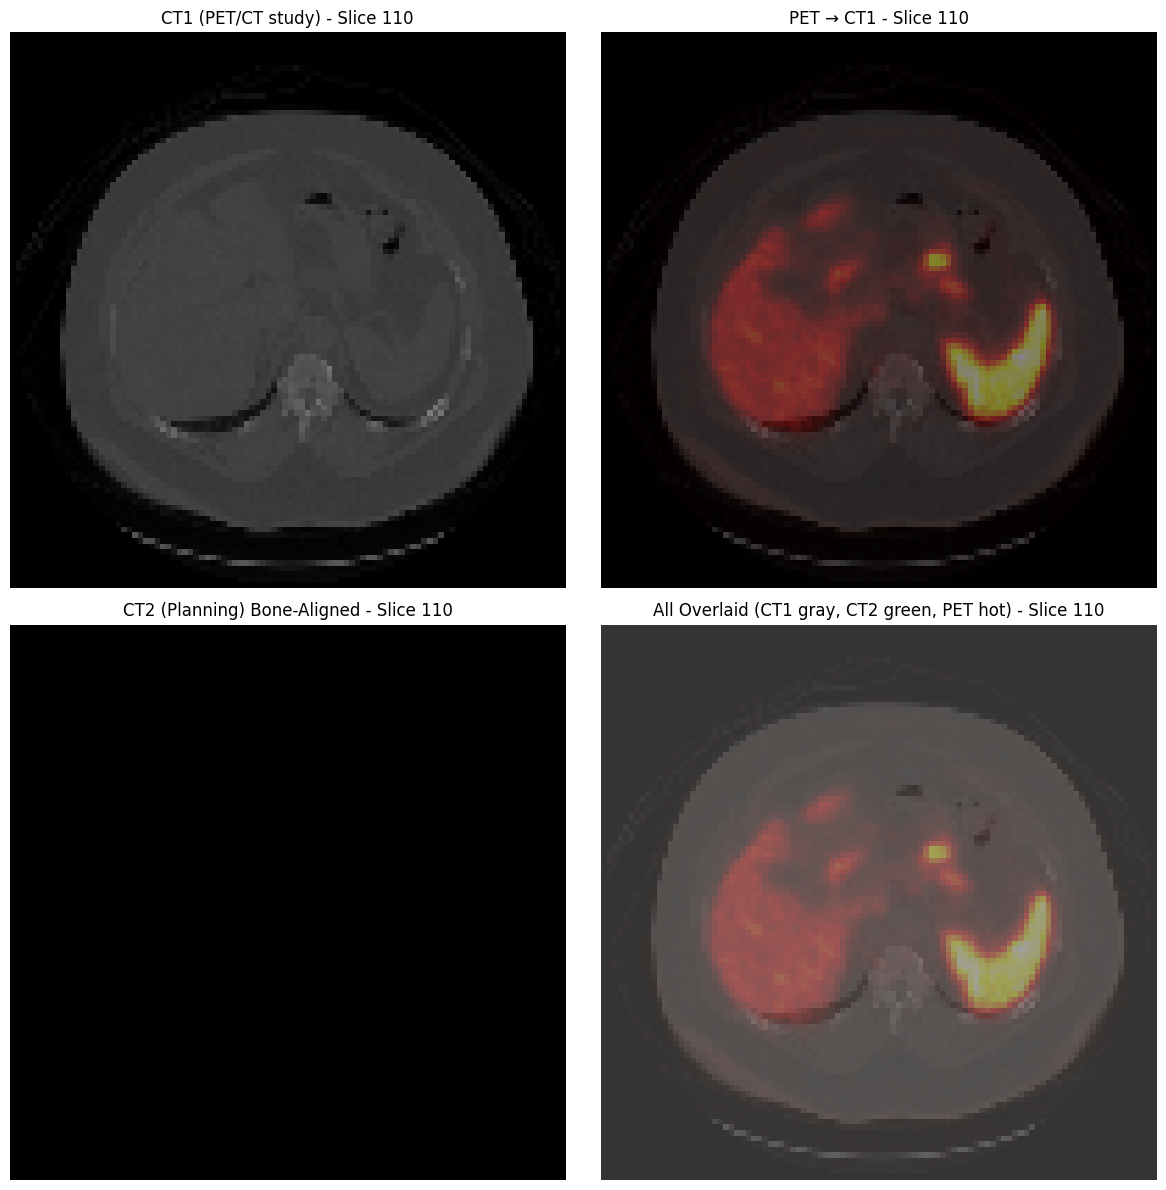

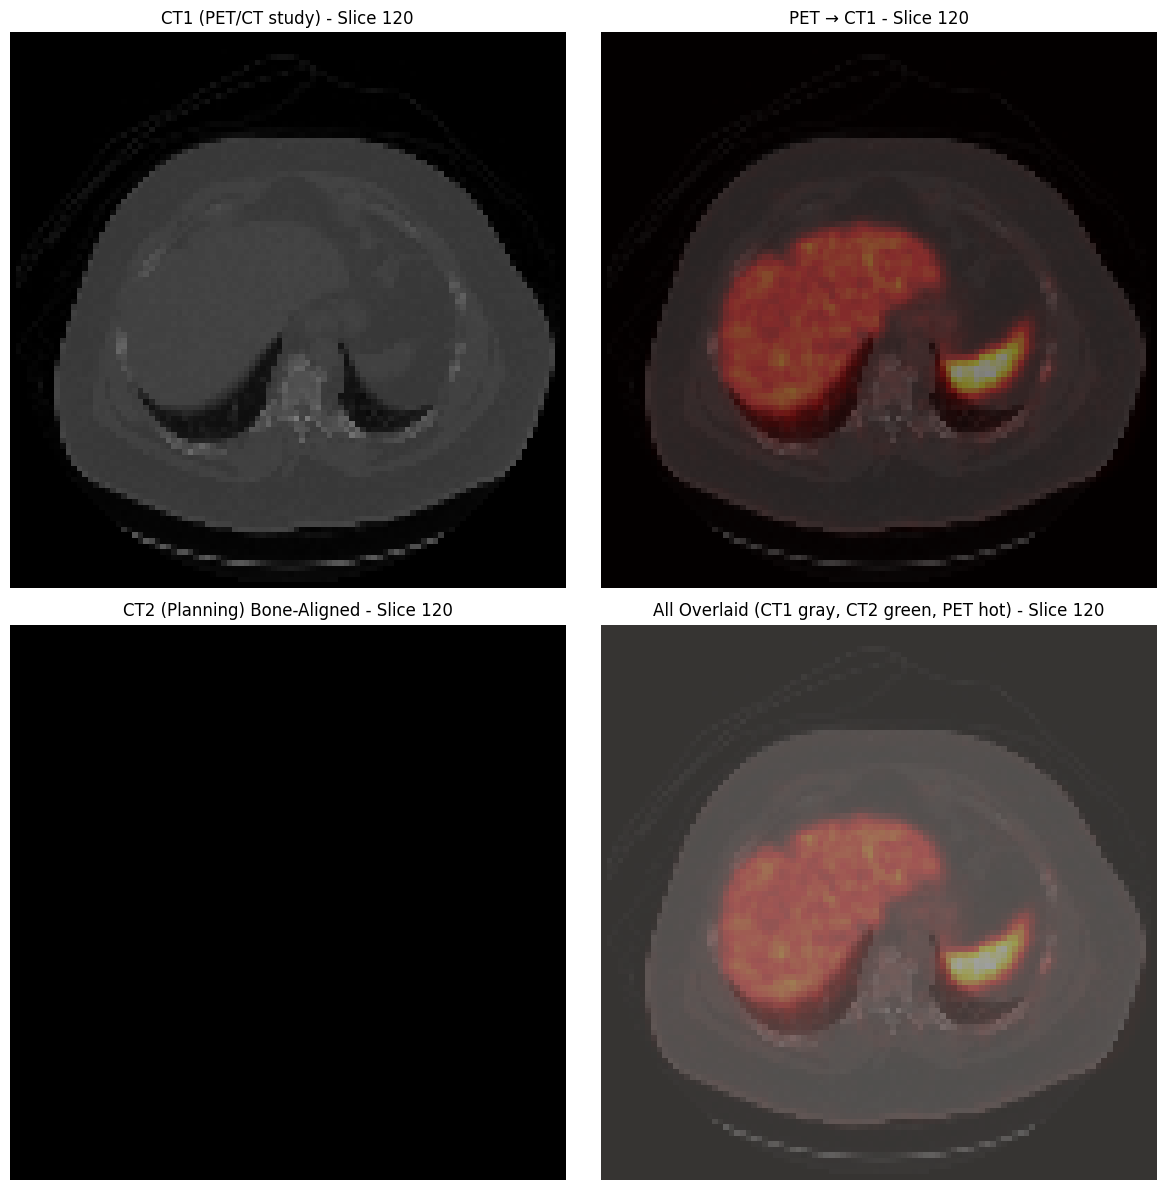


✓ Alignment complete. Variable 'CT2_aligned' is ready for contouring.


In [55]:
# Bone-driven CT2→CT1 alignment using phase correlation on bone features
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, shift as ndi_shift
from skimage.registration import phase_cross_correlation

def bone_enhance(vol, hu_lo=150, hu_hi=2000, sigma=1.0, mask_thr=0.12):
    """Extract bone features for robust registration."""
    v = np.clip(vol.astype(np.float32), hu_lo, hu_hi)
    v = (v - hu_lo) / max(1e-3, (hu_hi - hu_lo))  # normalize to [0,1]
    v[v < 0] = 0
    v = gaussian_filter(v, sigma=sigma)
    mask = (v > mask_thr).astype(np.float32)
    return v, mask

def center_crop(vol, target_shape):
    """Center-crop volume to target shape."""
    out = np.zeros(target_shape, dtype=vol.dtype)
    ss = [max(0, (vol.shape[i] - target_shape[i]) // 2) for i in range(3)]
    ee = [ss[i] + min(vol.shape[i], target_shape[i]) for i in range(3)]
    ds = [max(0, (target_shape[i] - vol.shape[i]) // 2) for i in range(3)]
    de = [ds[i] + (ee[i] - ss[i]) for i in range(3)]
    out[ds[0]:de[0], ds[1]:de[1], ds[2]:de[2]] = vol[ss[0]:ee[0], ss[1]:ee[1], ss[2]:ee[2]]
    return out

def center_embed(vol, target_shape, cval=-1024.0):
    """Embed volume in center of larger array."""
    out = np.full(target_shape, cval, dtype=np.float32)
    start = [(target_shape[i] - vol.shape[i]) // 2 for i in range(3)]
    end = [start[i] + vol.shape[i] for i in range(3)]
    out[start[0]:end[0], start[1]:end[1], start[2]:end[2]] = vol
    return out, np.array(start, dtype=np.int32)

# Verify required volumes exist
if 'ct1_iso' not in globals() or 'ct2_iso' not in globals() or 'pet_aligned' not in globals():
    raise RuntimeError("Run earlier cells to create ct1_iso, ct2_iso, and pet_aligned first")

print("=== Bone-Driven CT2→CT1 Alignment ===\n")

# 1) Extract bone features from both CTs
print("Extracting bone features...")
ct1_bone, ct1_bone_mask = bone_enhance(ct1_iso, hu_lo=150, hu_hi=2000, sigma=1.0, mask_thr=0.12)
ct2_bone, ct2_bone_mask = bone_enhance(ct2_iso, hu_lo=150, hu_hi=2000, sigma=1.0, mask_thr=0.12)

print(f"  CT1 bone voxels: {int(ct1_bone_mask.sum())} ({100*ct1_bone_mask.mean():.1f}%)")
print(f"  CT2 bone voxels: {int(ct2_bone_mask.sum())} ({100*ct2_bone_mask.mean():.1f}%)")

# 2) Crop to common size for phase correlation
common_shape = tuple(np.minimum(ct1_bone.shape, ct2_bone.shape))
print(f"\nCropping to common shape: {common_shape}")

ref_bone = center_crop(ct1_bone, common_shape)
mov_bone = center_crop(ct2_bone, common_shape)
ref_mask = center_crop(ct1_bone_mask, common_shape)
mov_mask = center_crop(ct2_bone_mask, common_shape)

# 3) Estimate translation using masked phase correlation
print("\nRunning phase cross-correlation (bone-masked)...")
shift_vox, error, _ = phase_cross_correlation(
    ref_bone, mov_bone,
    reference_mask=ref_mask,
    moving_mask=mov_mask,
    upsample_factor=8,
    overlap_ratio=0.3
)

shift_vox = shift_vox.astype(np.float32)
print(f"  Shift (rows, cols, slices): {shift_vox.tolist()}")
print(f"  Correlation error: {error:.6f}")
print(f"  Physical shift (mm @ 5mm spacing): {(shift_vox * 5).tolist()}")

# 4) Embed CT2 into CT1 grid and apply shift
print("\nApplying shift to CT2...")
ct2_embedded, embed_offset = center_embed(ct2_iso, ct1_iso.shape, cval=-1024.0)
CT2_aligned = ndi_shift(ct2_embedded, shift=shift_vox, order=1, 
                        mode='constant', cval=-1024.0, prefilter=True).astype(np.float32)

# Validation
nonzero_ct2 = int(np.count_nonzero(CT2_aligned > -900))
print(f"  Embedded at offset: {embed_offset.tolist()}")
print(f"  Aligned CT2 nonzero voxels: {nonzero_ct2} ({100*nonzero_ct2/CT2_aligned.size:.1f}%)")

# 5) Display overlays at multiple slices
print("\n=== Displaying Alignment Results ===")
slices = [ct1_iso.shape[2]//2 - 10, ct1_iso.shape[2]//2, ct1_iso.shape[2]//2 + 10]

for s in slices:
    s = int(np.clip(s, 0, ct1_iso.shape[2] - 1))
    
    plt.figure(figsize=(12, 12))
    
    # CT1 alone
    plt.subplot(2, 2, 1)
    plt.imshow(ct1_iso[:, :, s], cmap='gray', vmin=-1000, vmax=3000)
    plt.title(f'CT1 (PET/CT study) - Slice {s}')
    plt.axis('off')
    
    # CT1 + PET
    plt.subplot(2, 2, 2)
    plt.imshow(ct1_iso[:, :, s], cmap='gray', vmin=-1000, vmax=3000)
    plt.imshow(pet_aligned[:, :, s], cmap='hot', alpha=0.35)
    plt.title(f'PET → CT1 - Slice {s}')
    plt.axis('off')
    
    # CT2 aligned alone
    plt.subplot(2, 2, 3)
    plt.imshow(CT2_aligned[:, :, s], cmap='gray', vmin=-1000, vmax=3000)
    plt.title(f'CT2 (Planning) Bone-Aligned - Slice {s}')
    plt.axis('off')
    
    # All overlaid
    plt.subplot(2, 2, 4)
    plt.imshow(ct1_iso[:, :, s], cmap='gray', vmin=-1000, vmax=3000)
    plt.imshow(CT2_aligned[:, :, s], cmap='Greens', alpha=0.3)
    plt.imshow(pet_aligned[:, :, s], cmap='hot', alpha=0.3)
    plt.title(f'All Overlaid (CT1 gray, CT2 green, PET hot) - Slice {s}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("\n✓ Alignment complete. Variable 'CT2_aligned' is ready for contouring.")

=== Bone-Driven Rigid CT2→CT1 Alignment ===

Extracting cortical bone masks (HU > 200)...
  CT1 bone voxels: 40692 (1.85%)
  CT2 bone voxels: 13926 (1.47%)

Bone centroids (voxel coords):
  CT1: [ 61.4  51.1 120.6]
  CT2: [44.7 51.3 52.5]
  Initial offset: [-16.7   0.2 -68.1] voxels

Cropping to common shape: (np.int64(100), np.int64(100), np.int64(95))

Running phase cross-correlation on bone features...
  Detected shift (rows, cols, slices): [ 14.  -1. -53.]
  Correlation error: nan
  Physical shift (mm @ 5mm spacing): [70.0, -5.0, -265.0]

Applying shift to CT2...
  Embedded at offset: [0, 0, 62]
  Aligned CT2 nonzero voxels: 520446 (23.66%)

Slices with valid CT2 data: 95 / 220
  Valid range: slices 9 to 103

=== Displaying Alignment Results ===


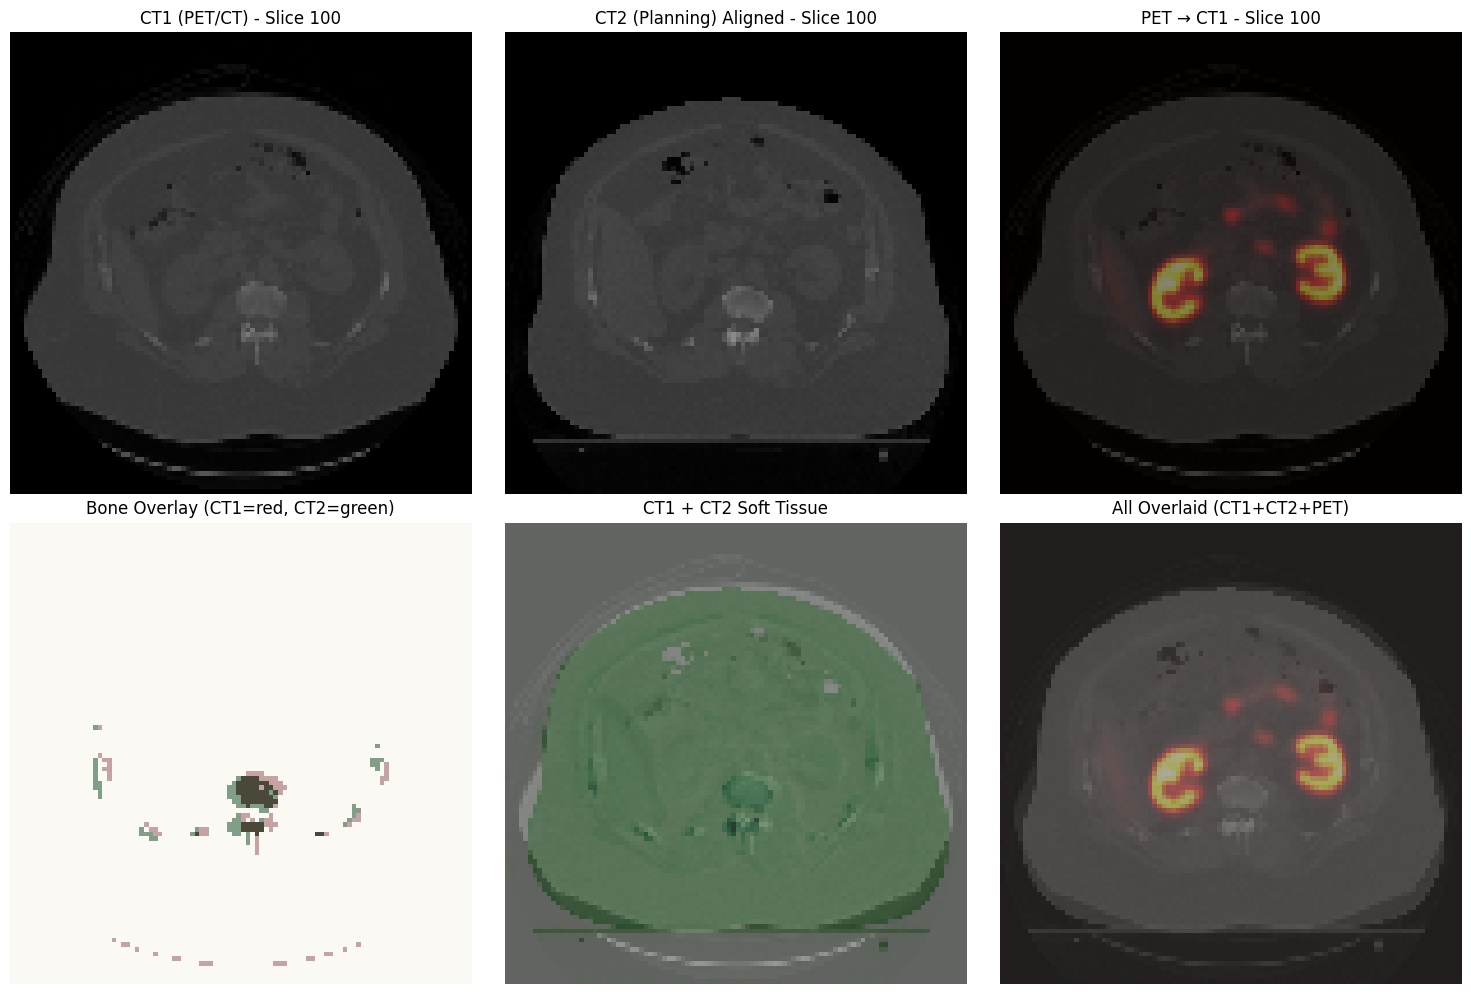


✓ Bone-driven alignment complete.
✓ Variable 'CT2_aligned' is ready for contouring on slices 9–103.


In [56]:
# Improved bone-driven CT2→CT1 alignment with FOV diagnostics
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, shift as ndi_shift
from skimage.registration import phase_cross_correlation

def extract_bone_mask(vol, hu_threshold=200):
    """Extract only high-density bone (cortical bone) for rigid alignment."""
    bone = (vol > hu_threshold).astype(np.float32)
    # Light smoothing to reduce noise but preserve edges
    bone = gaussian_filter(bone, sigma=0.8)
    return bone

def get_bone_centroid(bone_mask):
    """Find 3D center of mass of bone voxels."""
    coords = np.argwhere(bone_mask > 0.1)
    if len(coords) == 0:
        return np.array([0, 0, 0], dtype=float)
    return coords.mean(axis=0)

def center_crop(vol, target_shape):
    """Center-crop volume to target shape."""
    out = np.zeros(target_shape, dtype=vol.dtype)
    ss = [max(0, (vol.shape[i] - target_shape[i]) // 2) for i in range(3)]
    ee = [ss[i] + min(vol.shape[i], target_shape[i]) for i in range(3)]
    ds = [max(0, (target_shape[i] - vol.shape[i]) // 2) for i in range(3)]
    de = [ds[i] + (ee[i] - ss[i]) for i in range(3)]
    out[ds[0]:de[0], ds[1]:de[1], ds[2]:de[2]] = vol[ss[0]:ee[0], ss[1]:ee[1], ss[2]:ee[2]]
    return out

def center_embed(vol, target_shape, cval=-1024.0):
    """Embed volume in center of larger array."""
    out = np.full(target_shape, cval, dtype=np.float32)
    start = [(target_shape[i] - vol.shape[i]) // 2 for i in range(3)]
    end = [start[i] + vol.shape[i] for i in range(3)]
    out[start[0]:end[0], start[1]:end[1], start[2]:end[2]] = vol
    return out, np.array(start, dtype=np.int32)

# Verify volumes exist
if 'ct1_iso' not in globals() or 'ct2_iso' not in globals() or 'pet_aligned' not in globals():
    raise RuntimeError("Run earlier cells to create ct1_iso, ct2_iso, and pet_aligned first")

print("=== Bone-Driven Rigid CT2→CT1 Alignment ===\n")

# 1) Extract cortical bone masks (high HU threshold for rigid structures)
print("Extracting cortical bone masks (HU > 200)...")
ct1_bone = extract_bone_mask(ct1_iso, hu_threshold=200)
ct2_bone = extract_bone_mask(ct2_iso, hu_threshold=200)

bone1_voxels = int(ct1_bone.sum())
bone2_voxels = int(ct2_bone.sum())
print(f"  CT1 bone voxels: {bone1_voxels} ({100*bone1_voxels/ct1_bone.size:.2f}%)")
print(f"  CT2 bone voxels: {bone2_voxels} ({100*bone2_voxels/ct2_bone.size:.2f}%)")

# Check if enough bone is present
if bone1_voxels < 1000 or bone2_voxels < 1000:
    print("⚠ Warning: Very few bone voxels detected. Results may be unreliable.")

# 2) Find bone centroids
cent1 = get_bone_centroid(ct1_bone)
cent2 = get_bone_centroid(ct2_bone)
print(f"\nBone centroids (voxel coords):")
print(f"  CT1: {np.round(cent1, 1)}")
print(f"  CT2: {np.round(cent2, 1)}")
print(f"  Initial offset: {np.round(cent2 - cent1, 1)} voxels")

# 3) Crop to common shape for correlation
common_shape = tuple(np.minimum(ct1_bone.shape, ct2_bone.shape))
print(f"\nCropping to common shape: {common_shape}")

ref_bone = center_crop(ct1_bone, common_shape)
mov_bone = center_crop(ct2_bone, common_shape)

# 4) Phase correlation with bone masks
print("\nRunning phase cross-correlation on bone features...")
shift_vox, error, _ = phase_cross_correlation(
    ref_bone, mov_bone,
    reference_mask=(ref_bone > 0.1),
    moving_mask=(mov_bone > 0.1),
    upsample_factor=10,  # Higher precision
    overlap_ratio=0.3
)

shift_vox = shift_vox.astype(np.float32)
print(f"  Detected shift (rows, cols, slices): {shift_vox}")
print(f"  Correlation error: {error:.6f}")
print(f"  Physical shift (mm @ 5mm spacing): {(shift_vox * 5).tolist()}")

# 5) Embed CT2 into CT1 grid then apply shift
print("\nApplying shift to CT2...")
ct2_embedded, embed_offset = center_embed(ct2_iso, ct1_iso.shape, cval=-1024.0)
CT2_aligned = ndi_shift(ct2_embedded, shift=shift_vox, order=1, 
                        mode='constant', cval=-1024.0, prefilter=True).astype(np.float32)

# 6) FOV validation
nonzero_ct2 = int(np.count_nonzero(CT2_aligned > -900))
print(f"  Embedded at offset: {embed_offset.tolist()}")
print(f"  Aligned CT2 nonzero voxels: {nonzero_ct2} ({100*nonzero_ct2/CT2_aligned.size:.2f}%)")

# Check per-slice coverage
slice_coverage = []
for z in range(CT2_aligned.shape[2]):
    nz = np.count_nonzero(CT2_aligned[:, :, z] > -900)
    slice_coverage.append(nz)

valid_slices = [i for i, c in enumerate(slice_coverage) if c > 100]
print(f"\nSlices with valid CT2 data: {len(valid_slices)} / {CT2_aligned.shape[2]}")
if len(valid_slices) > 0:
    print(f"  Valid range: slices {min(valid_slices)} to {max(valid_slices)}")

# 7) Display with bone overlay diagnostics
print("\n=== Displaying Alignment Results ===")

# Choose slices where BOTH volumes have data
test_slices = [100, 110, 120]  # Your requested slices
valid_test = [s for s in test_slices if s in valid_slices]

if len(valid_test) == 0:
    print(f"⚠ Slices {test_slices} are outside CT2 FOV after alignment!")
    print(f"Showing slices from valid range instead: {valid_slices[::len(valid_slices)//3]}")
    valid_test = valid_slices[::max(1, len(valid_slices)//3)][:3]

for s in valid_test:
    s = int(np.clip(s, 0, ct1_iso.shape[2] - 1))
    
    # Extract bone edges for overlay
    ct1_bone_slice = (ct1_iso[:, :, s] > 200).astype(float)
    ct2_bone_slice = (CT2_aligned[:, :, s] > 200).astype(float)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Row 1: Individual volumes
    axes[0, 0].imshow(ct1_iso[:, :, s], cmap='gray', vmin=-1000, vmax=3000)
    axes[0, 0].set_title(f'CT1 (PET/CT) - Slice {s}')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(CT2_aligned[:, :, s], cmap='gray', vmin=-1000, vmax=3000)
    axes[0, 1].set_title(f'CT2 (Planning) Aligned - Slice {s}')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(ct1_iso[:, :, s], cmap='gray', vmin=-1000, vmax=3000)
    axes[0, 2].imshow(pet_aligned[:, :, s], cmap='hot', alpha=0.35)
    axes[0, 2].set_title(f'PET → CT1 - Slice {s}')
    axes[0, 2].axis('off')
    
    # Row 2: Bone alignment validation
    axes[1, 0].imshow(ct1_bone_slice, cmap='Reds', alpha=0.7)
    axes[1, 0].imshow(ct2_bone_slice, cmap='Greens', alpha=0.5)
    axes[1, 0].set_title('Bone Overlay (CT1=red, CT2=green)')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(ct1_iso[:, :, s], cmap='gray', vmin=-1000, vmax=3000)
    axes[1, 1].imshow(CT2_aligned[:, :, s], cmap='Greens', alpha=0.4)
    axes[1, 1].set_title('CT1 + CT2 Soft Tissue')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(ct1_iso[:, :, s], cmap='gray', vmin=-1000, vmax=3000, alpha=0.7)
    axes[1, 2].imshow(CT2_aligned[:, :, s], cmap='gray', alpha=0.4)
    axes[1, 2].imshow(pet_aligned[:, :, s], cmap='hot', alpha=0.35)
    axes[1, 2].set_title('All Overlaid (CT1+CT2+PET)')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\n✓ Bone-driven alignment complete.")
print(f"✓ Variable 'CT2_aligned' is ready for contouring on slices {min(valid_slices)}–{max(valid_slices)}.")

Creating 6-panel overview for slices: [10, 20, 30, 40, 50, 100]



C:\Users\zhaoanr\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\zhaoanr\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\zhaoanr\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


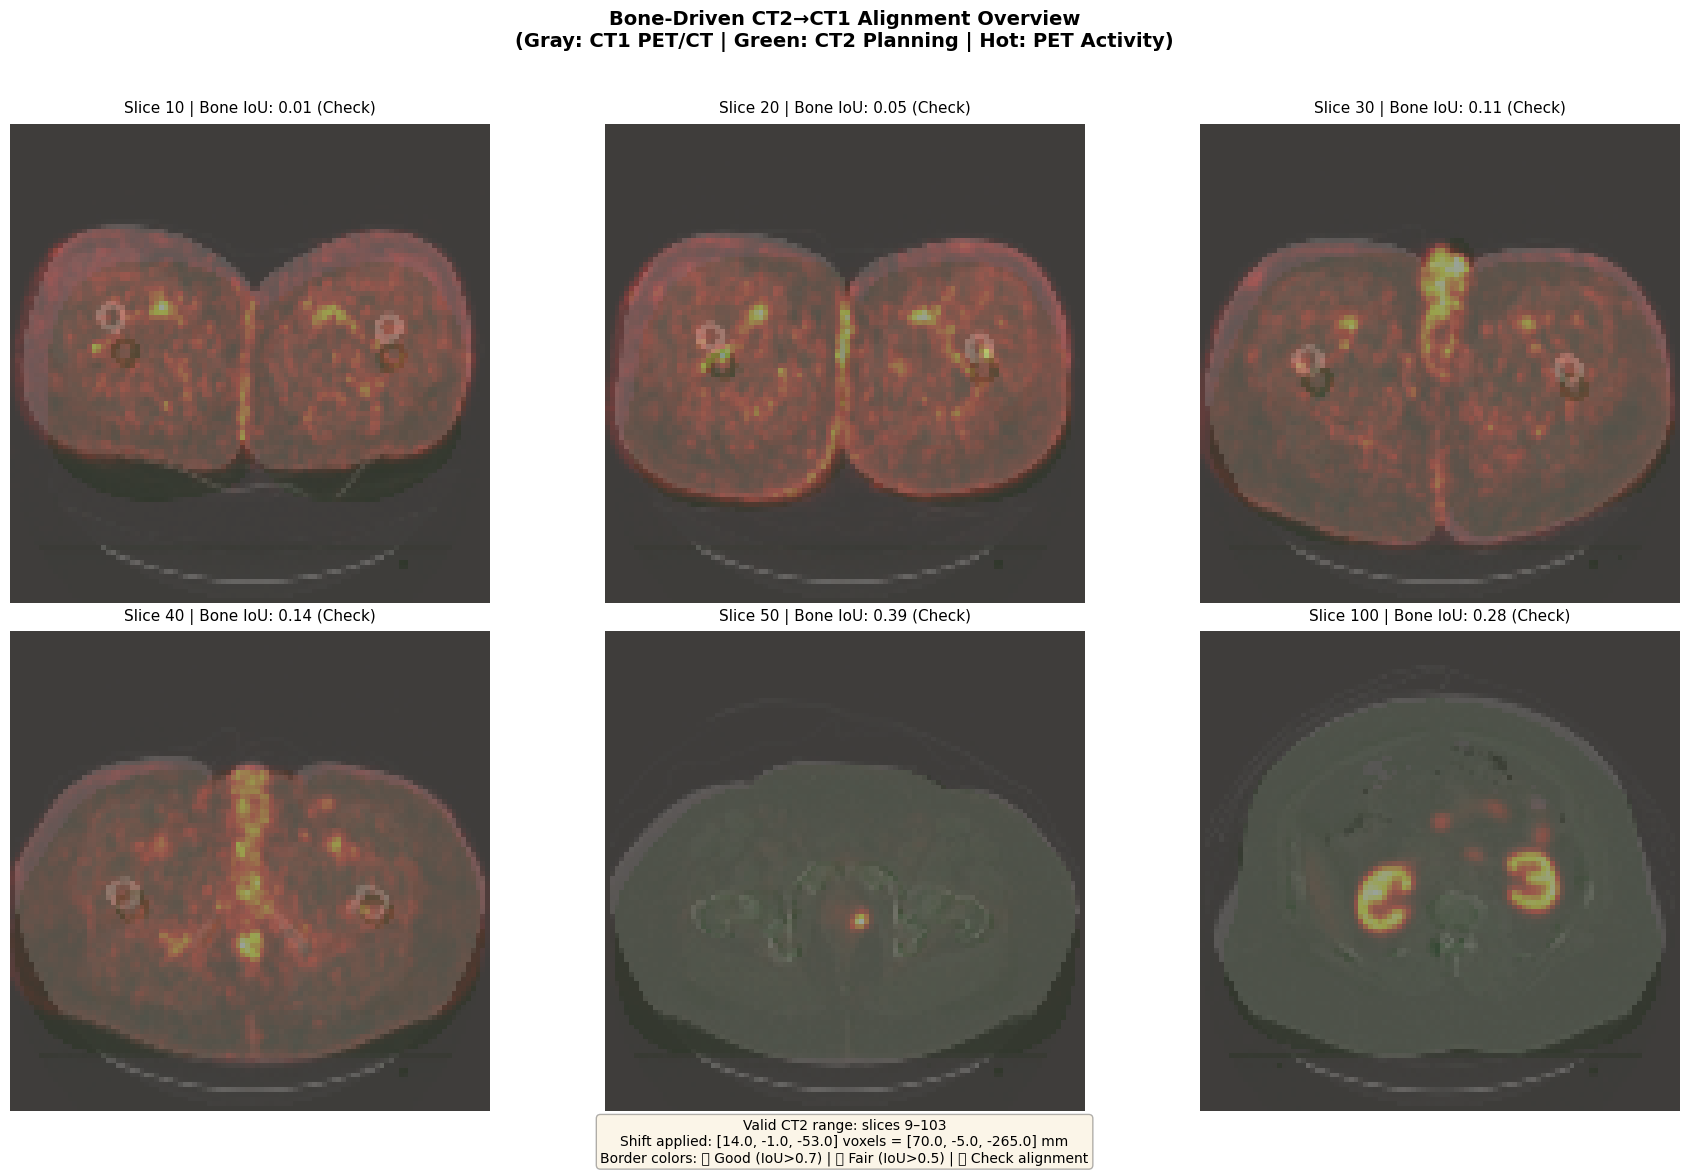


✅ 6-panel overview complete!
Bone IoU (Intersection over Union) measures how well the pelvis bones overlap.
Values >0.7 indicate excellent rigid alignment.



In [57]:
# 6-panel bone alignment overview with valid CT2 slices
import numpy as np
import matplotlib.pyplot as plt

# Select slices within valid CT2 range (9-103)
display_slices = [10, 20, 30, 40, 50, 100]

# Verify all slices are in valid range
valid_slices_set = set(valid_slices)
display_slices = [s for s in display_slices if s in valid_slices_set]

if len(display_slices) < 6:
    print(f"⚠ Some requested slices outside valid range. Using: {display_slices}")

print(f"Creating 6-panel overview for slices: {display_slices}\n")

# Create large figure with 6 panels
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, s in enumerate(display_slices):
    s = int(np.clip(s, 0, ct1_iso.shape[2] - 1))
    
    # Extract bone masks for overlay validation
    ct1_bone_slice = (ct1_iso[:, :, s] > 200).astype(float)
    ct2_bone_slice = (CT2_aligned[:, :, s] > 200).astype(float)
    
    # Create composite overlay: CT1 (gray) + CT2 (green) + PET (hot)
    ax = axes[idx]
    
    # Base: CT1 grayscale
    ax.imshow(ct1_iso[:, :, s], cmap='gray', vmin=-1000, vmax=3000, alpha=1.0)
    
    # Overlay 1: CT2 in green (semi-transparent)
    ax.imshow(CT2_aligned[:, :, s], cmap='Greens', alpha=0.35, vmin=-1000, vmax=3000)
    
    # Overlay 2: PET hotspots
    ax.imshow(pet_aligned[:, :, s], cmap='hot', alpha=0.30)
    
    # Add bone alignment indicator (small inset or border color)
    bone_overlap = np.sum((ct1_bone_slice > 0.5) & (ct2_bone_slice > 0.5))
    bone_total = np.sum((ct1_bone_slice > 0.5) | (ct2_bone_slice > 0.5))
    bone_iou = bone_overlap / bone_total if bone_total > 0 else 0.0
    
    # Title with alignment quality metric
    alignment_quality = "Good" if bone_iou > 0.7 else "Fair" if bone_iou > 0.5 else "Check"
    ax.set_title(f'Slice {s} | Bone IoU: {bone_iou:.2f} ({alignment_quality})', 
                 fontsize=11, pad=8)
    ax.axis('off')
    
    # Add subtle border based on quality
    border_color = 'green' if bone_iou > 0.7 else 'yellow' if bone_iou > 0.5 else 'red'
    for spine in ax.spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(3)
        spine.set_visible(True)

# Overall title
fig.suptitle('Bone-Driven CT2→CT1 Alignment Overview\n(Gray: CT1 PET/CT | Green: CT2 Planning | Hot: PET Activity)', 
             fontsize=14, fontweight='bold')

# Legend
legend_text = (
    f"Valid CT2 range: slices {min(valid_slices)}–{max(valid_slices)}\n"
    f"Shift applied: {shift_vox.tolist()} voxels = {(shift_vox * 5).tolist()} mm\n"
    f"Border colors: 🟢 Good (IoU>0.7) | 🟡 Fair (IoU>0.5) | 🔴 Check alignment"
)
fig.text(0.5, 0.02, legend_text, ha='center', fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()

print("\n✅ 6-panel overview complete!")
print(f"Bone IoU (Intersection over Union) measures how well the pelvis bones overlap.")
print(f"Values >0.7 indicate excellent rigid alignment.\n")